In [1]:
# %pip -q install --upgrade pip
# %pip -q install vaex scikit-learn control pymoo salib 'numpy<=1.26' matplotlib pandas scipy sympy scienceplots

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.optimization import MyOptimizationProblem, convert_to_model_params, plot_optimization_params, plot_optimization_error, plot_compare, compute_metrics, estimate_polynomial_coefficient_bounds, save_model_params_to_json, load_model_params_from_json
from utils.data import get_events, get_sections, load_df, process_df, export_dataframe_to_latex
from utils.sensitivity_analysis import describe_param_with_uniform_distribution, describe_param_with_log_uniform_distribution, describe_param_with_triangular_distribution, describe_param_with_normal_distribution, describe_param_with_truncated_normal_distribution, describe_param_with_log_normal_distribution, wrapped_model_function, create_problem_spec_and_sample, plot_sampled_distribuitions, evaluate_problem, analyze_time_step, analyze_problem, sobol_sensitivity_analysis_from_model_params_to_outputs, plot_sensitivity_analysis, plot_sensitivity_analysis_heatmaps, get_region_mean, plot_sensitivity_analysis_bars

import warnings
warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/tex/'

# Data

Train size ≃ 3.28%
Test size ≃ 96.72%


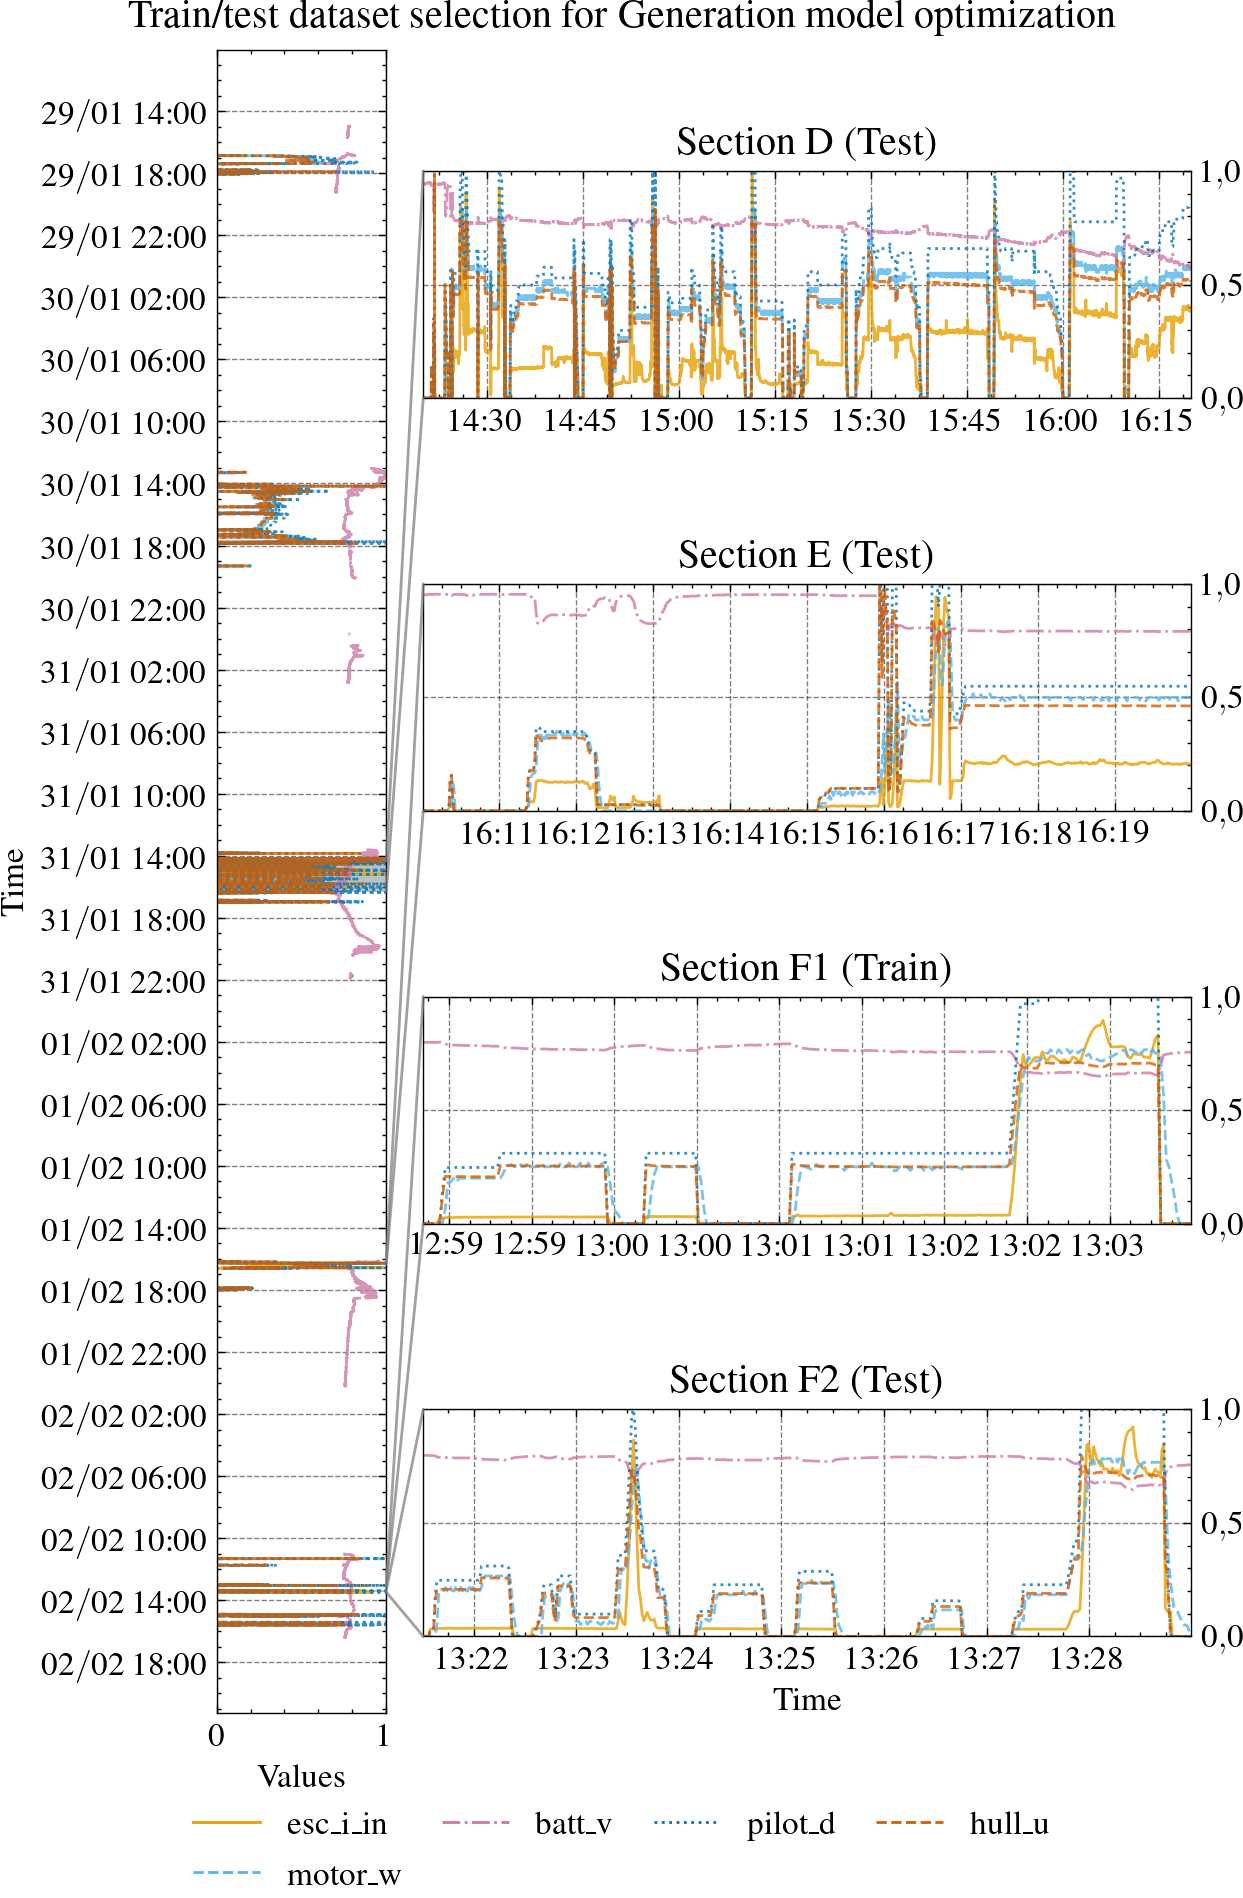

In [3]:
# filename = "../../../models/2020/boat_data_100ms.csv"
filename = "../../../models/2020/boat_data_1s.csv"
rename_columns = {
    'Battery Pack Voltage': 'batt_v',
    # 'Battery Current': 'batt_i',
    'ESC Duty Cycle': 'pilot_d',
    'Motor Angular Speed': 'motor_w',
    # 'ESC Input Power': 'esc_p_in',
    'ESC Input Current': 'esc_i_in',
    # **{f'MPPT {i} Input Current': f'mppt{i}_i_in' for i in range(1,5)},
    # **{f'MPPT {i} Input Voltage': f'mppt{i}_v_in' for i in range(1,5)},
    # **{f'MPPT {i} Duty Cycle': f'mppt{i}_d' for i in range(1,5)},
    # **{f'MPPT {i} Output Current': f'mppt{i}_i_out' for i in range(1,5)},
    # 'MPPTs Output Current': 'mppts_i_out',
    # 'PVs G': 'pv_g',
    # 'Solar POA': 'solar_poa',
    # 'Wind Speed': 'wind_v',
    # 'Air Temperature': 'air_t',
}

df = load_df(
    filename=filename,
    start=None,
    end=None,
    resample_rule=None,
    rename_columns=rename_columns,
    print_columns=False,
    iqr_threshold=None,
    cutoff_freq=None,
    sampling_rate=1,
    order=1,
)

sections, tzinfo = get_sections()

# Customizing ranges:
sections.loc['Section D', 'start'] = pd.Timestamp('2020-01-31 14:20:00')
sections.loc['Section D', 'end'] = pd.Timestamp('2020-01-31 16:20:00')
sections.loc['Section E', 'end'] = pd.Timestamp('2020-02-01 16:20:00')
sections.loc['Section F1'] = [pd.Timestamp('2020-02-02 12:58:50'), pd.Timestamp('2020-02-02 13:03:30')]
sections.loc['Section F2'] = [pd.Timestamp('2020-02-02 13:21:30'), pd.Timestamp('2020-02-02 13:29:00')]
sections = sections.loc[['Section D', 'Section E', 'Section F1', 'Section F2']]

# train_section_name = 'Section D'
train_section_name = 'Section F1'
train_test_sections = sections.reset_index().to_dict(orient='records')
train_section = sections.loc[sections.index == train_section_name].reset_index().to_dict(orient='records')[0]
test_sections = sections.loc[sections.index != train_section_name].reset_index().to_dict(orient='records')

train_size = 0
test_size = 0
for i in range(len(train_test_sections)):
    if train_test_sections[i]['name'] == train_section_name:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Train)'
        train_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size
    else:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Test)'
        test_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size


total_size = train_size+test_size
print(f'Train size ≃ {100*train_size/total_size:.2f}%')
print(f'Test size ≃ {100*test_size/total_size:.2f}%')


def boat_speed_from_motor_v(motor_v, a=0.54340307/3.6):
    return a*motor_v  # [m/s]

df['hull_u'] = boat_speed_from_motor_v(df['batt_v']*df['pilot_d'])

fig_save_and_show(
        filename=None,#f'{latex_img_path}/generation_optimization_test_residuals_{col}.pdf',
        show_title=f'Train/test dataset selection for Generation model optimization',
        save_title=f'Dataset da embarcação durante o DSB de 2019',
        ncol=4,
        fig=plot_events_data(
            events=train_test_sections,
            df=df,
            column_names=['esc_i_in', 'motor_w', 'batt_v', 'pilot_d', 'hull_u'],
            normalize=True,
        )
    )


# Propulsion System model

In [4]:
from model import Propulsion, get_hull_areas

from utils.models import eval_poly

Propulsion.build({})

<NonlinearIOSystem propulsion: ['batt_v', 'pilot_d'] -> ['motor_v', 'motor_w', 'motor_i', 'motor_q_load', 'esc_d', 'esc_i_in', 'prop_w', 'prop_J', 'prop_k_q', 'prop_k_T', 'prop_q', 'prop_t', 'hull_u', 'hull_r']>

In [5]:
motor_params_loaded = load_model_params_from_json('../../../models/2020/motor/me0909_free_rotor_step_params.json')
esc_params_loaded = load_model_params_from_json('../../../models/2020/esc/mam17_params.json')
propulsive_initial_params = load_model_params_from_json('../../../models/2020/propeller/data/propulsive_initial_params.json')

In [6]:
propulsion_params = motor_params_loaded | esc_params_loaded | {
    'rho_water': propulsive_initial_params['water_rho'],  # Estimated from public ocean dataset
    'rho_air': propulsive_initial_params['air_rho'],  # Estimated from public ocean dataset
    'esc_tau_fall': 0.5,  # Unknown
    'esc_tau_rise': 1.5,  # Unknown
    'trans_eta': propulsive_initial_params['trans_eta'],  # Arbitrary
    'trans_I_r_in': 0,  # Ignored
    'trans_I_r_out': 0,  # Ignored
    'trans_k': propulsive_initial_params['trans_k'],  # Manually counted
    'prop_D': propulsive_initial_params['prop_D'],  # From manufacturer's specs
    'prop_k_T_coeffs': propulsive_initial_params['prop_k_T_coeffs'],
    'prop_k_Q_coeffs': propulsive_initial_params['prop_k_Q_coeffs'],
    'prop_eta_R': 1.0,  # Unknown
    'prop_I_r': propulsive_initial_params['prop_I_r'],  # Estiamted from dimensions
    'hull_C_T': propulsive_initial_params['hull_C_T'],  # Estimated from data
    'hull_M': propulsive_initial_params['hull_M'],  # Measured (fully loaded, with pilot)
    'hull_M_a': 0,  # Unknown
    'hull_S_water': propulsive_initial_params['hull_S_water'],  # Estimated from hydrostatics
    'hull_S_air': propulsive_initial_params['hull_S_air'],  # Estimated from hydrostatics
    'hull_T_ded': propulsive_initial_params['hull_T_ded'],  # Estimated from models/2020/propeller/propeller.ipynb
    'hull_W': propulsive_initial_params['hull_W'],  # Estimated from models/2020/propeller/propeller.ipynb
}
propulsion_params

{'motor_B': 0.0012793008044770459,
 'motor_I_r': 0.011828773027862982,
 'motor_I_r_load': 0,
 'motor_K_Q': 0.10543193741528227,
 'motor_K_V': 0.10337093946599393,
 'motor_L_A': 6.336356266841513e-05,
 'motor_R_A': 0.019579524515654242,
 'esc_E_off': 0.00011,
 'esc_E_on': 7e-05,
 'esc_F_s': 12550,
 'esc_Q_rr': 1.9e-07,
 'esc_R_ds_on': 0.008256754167097705,
 'esc_V_F': 3.338359854985,
 'esc_V_ds_ov': 2.0,
 'esc_r_D': 0.004027165799996619,
 'rho_water': 1023,
 'rho_air': 1.1839,
 'esc_tau_fall': 0.5,
 'esc_tau_rise': 1.5,
 'trans_eta': 0.95,
 'trans_I_r_in': 0,
 'trans_I_r_out': 0,
 'trans_k': 0.6363636363636364,
 'prop_D': 0.2286,
 'prop_k_T_coeffs': array([ 0.3721783 , -0.10836846, -0.16738142,  0.028249  ]),
 'prop_k_Q_coeffs': array([ 0.05473053, -0.01755624, -0.00053339, -0.01076869]),
 'prop_eta_R': 1.0,
 'prop_I_r': 0.0005545487788185924,
 'hull_C_T': 0.00830774302162304,
 'hull_M': 293.7,
 'hull_M_a': 0,
 'hull_S_water': 4.050226176680205,
 'hull_S_air': 4.188174709710495,
 'hull_

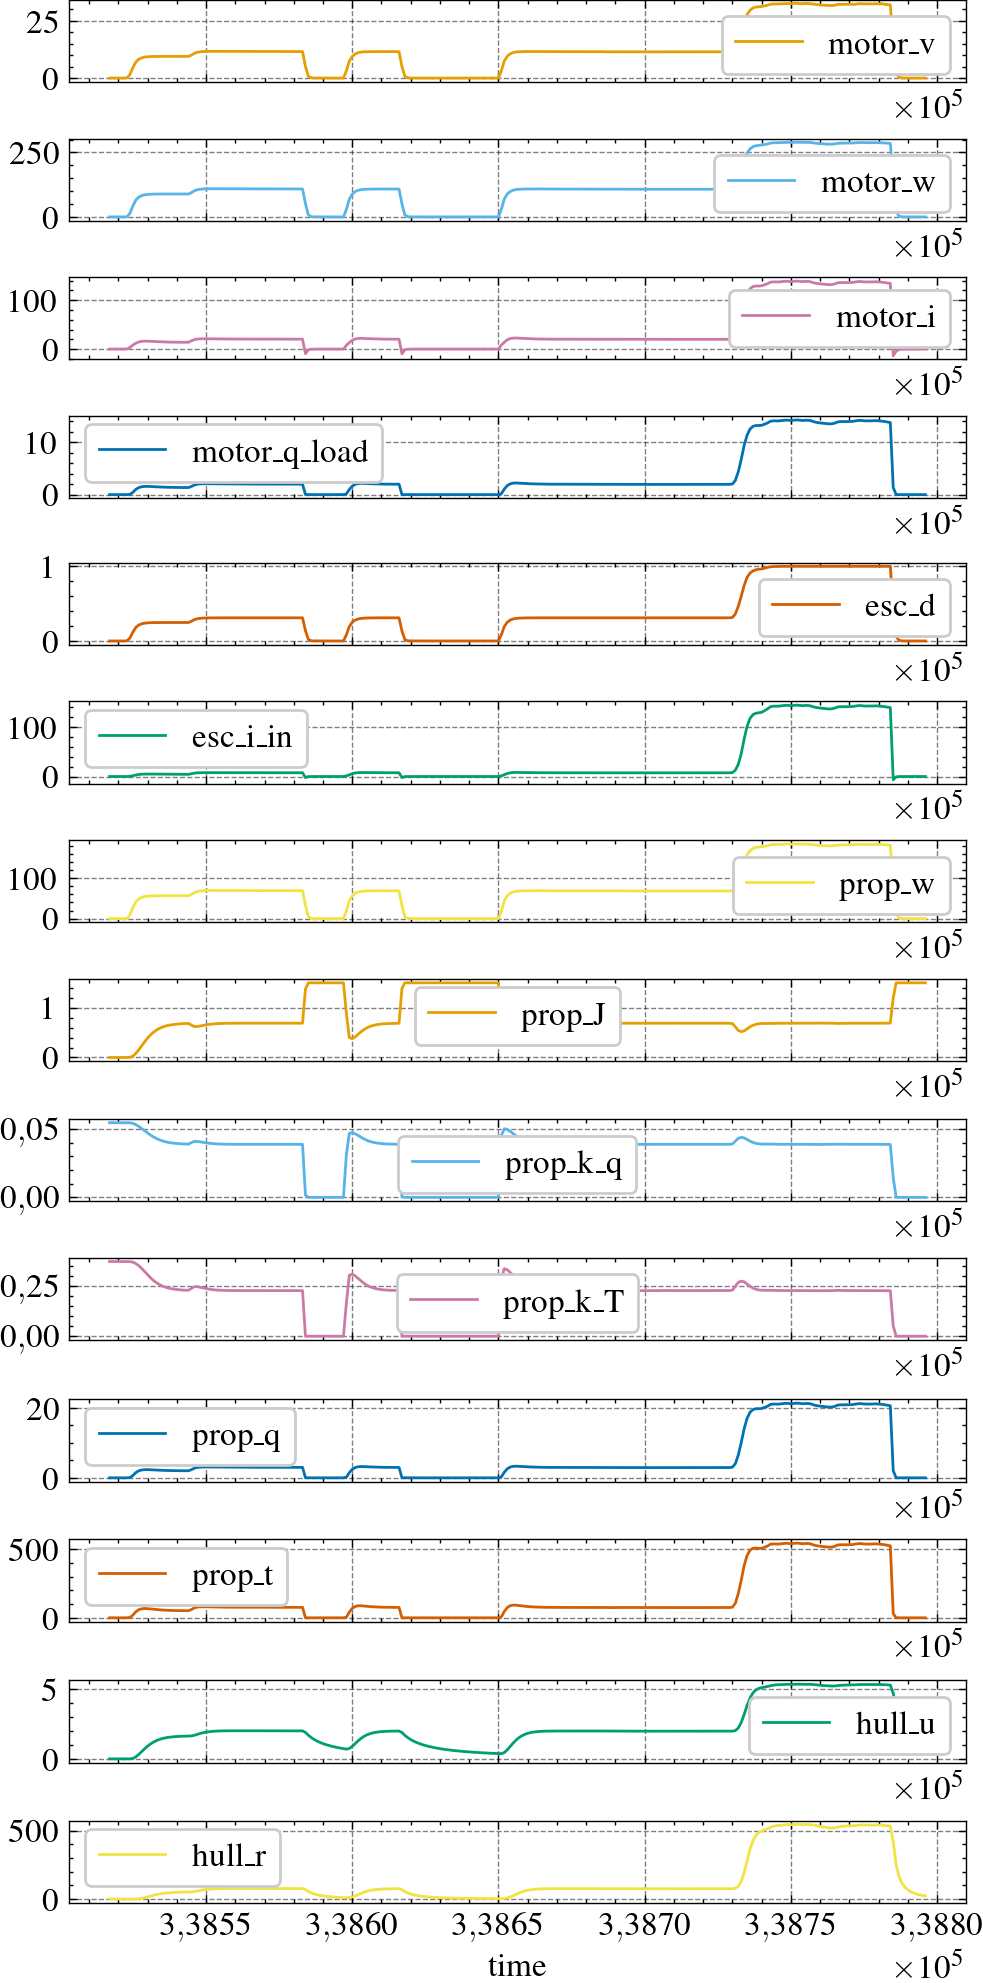

In [7]:
# Select the optimization data
data_cols = ['motor_w', 'esc_i_in', 'hull_u']
input_cols = ['batt_v', 'pilot_d']

df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols][:1000]

# Time array
T = np.ascontiguousarray(df_train['t'].to_numpy())

# Inputs
U = np.ascontiguousarray(df_train[input_cols].to_numpy().T)

# Model
propulsion = Propulsion.build(propulsion_params)

# Initial state
X0 = Propulsion.initial_state(
    X0=dict(),
    U0=U[:,0],
    params=propulsion_params,
)

# Simulation
res = ct.input_output_response(propulsion, T=T, U=U, X0=X0, solve_ivp_method='Radau') # type: ignore
ydata = res.to_pandas().set_index('time')[res.output_labels]

ydata.plot(subplots=True, figsize=(5,10))
plt.show()

# Optimization

In [8]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.parallelization.starmap import StarmapParallelization
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool

In [9]:
import numpy as np
from dataclasses import dataclass
from typing import Sequence, Optional

def _collect_coeffs(x: np.ndarray,
                    opt_param_order: Sequence[str],
                    prefix: str) -> np.ndarray:
    """Extract polynomial coeffs for a given prefix from x."""
    coeffs = []
    for i, name in enumerate(opt_param_order):
        if name.startswith(prefix + "_"):
            coeffs.append(float(x[i]))
    return np.asarray(coeffs, dtype=float)

@dataclass
class HullWakeConstraint:
    """
    Penalize hull_W far from a reference value, and outside [w_min, w_max].

    violation = max( |w - w_ref| - tol, w_min - w, w - w_max, 0 )
    """
    opt_param_order: Sequence[str]
    name: str = "hull_W"
    w_ref: float = 0.1425
    tol: float = 0.05     # allowed ± band without penalty
    w_min: float = 0.0
    w_max: float = 0.4

    def __call__(self, x: np.ndarray) -> float:
        # locate hull_W in x
        try:
            idx = self.opt_param_order.index(self.name)
        except ValueError:
            # not being optimized here -> no violation
            return -1.0

        w = float(x[idx])

        # box constraint: w_min <= w <= w_max
        box_low  = self.w_min - w
        box_high = w - self.w_max

        # soft prior around w_ref
        prior_violation = abs(w - self.w_ref) - self.tol

        violation = max(box_low, box_high, prior_violation, 0.0)
        return float(violation)
    
@dataclass
class HullThrustDeductionConstraint:
    """
    Enforce:
      - 0 <= t <= t_max
      - t ≈ k_R * w with k_R in [kR_min, kR_max]
    where:
      w = hull_W
      t = hull_T_ded
    """
    opt_param_order: Sequence[str]
    wake_name: str = "hull_W"
    tded_name: str = "hull_T_ded"
    t_max: float = 0.3
    kR_min: float = 0.4
    kR_max: float = 0.8

    def __call__(self, x: np.ndarray) -> float:
        names = self.opt_param_order
        try:
            i_w = names.index(self.wake_name)
            i_t = names.index(self.tded_name)
        except ValueError:
            # not both present -> inactive
            return -1.0

        w = float(x[i_w])
        t = float(x[i_t])

        # basic box constraints on t
        low_violation  = -t          # t >= 0
        high_violation = t - self.t_max   # t <= t_max

        # if w <= 0, we can't define k_R properly; penalize strongly
        if w <= 0.0:
            kR_violation = 1.0
        else:
            kR = t / w
            kR_low  = self.kR_min - kR
            kR_high = kR - self.kR_max
            kR_violation = max(kR_low, kR_high, 0.0)

        violation = max(low_violation, high_violation, kR_violation, 0.0)
        return float(violation)

@dataclass
class PolyOutputConstraint:
    """
    Enforce k_min <= k(J) <= k_max over J in [J_min, J_max].

    No monotonicity here; only box bounds on the curve values.
    """
    opt_param_order: Sequence[str]
    coeff_name_prefix: str
    J_min: float = 0.0
    J_max: float = 1.5
    n_grid: int = 80
    k_min: Optional[float] = None
    k_max: Optional[float] = None

    def __post_init__(self):
        self.J_grid = np.linspace(self.J_min, self.J_max, self.n_grid)

    def __call__(self, x: np.ndarray) -> float:
        coeffs = _collect_coeffs(x, self.opt_param_order, self.coeff_name_prefix)
        if coeffs.size == 0:
            return -1.0

        k_vals = eval_poly(coeffs, self.J_grid)

        v_low = 0.0
        v_high = 0.0
        if self.k_min is not None:
            v_low = np.max(self.k_min - k_vals)   # >0 if any point < k_min
        if self.k_max is not None:
            v_high = np.max(k_vals - self.k_max)  # >0 if any point > k_max

        return float(max(v_low, v_high, 0.0))

@dataclass
class EfficiencyConstraint:
    """
    Enforce 0 <= eta0(J) <= eta_max, where
        eta0(J) = J*K_T(J) / (2*pi*K_Q(J))
    over J in [J_min, J_max].
    """
    opt_param_order: Sequence[str]
    kt_prefix: str
    kq_prefix: str
    J_min: float = 0.1
    J_max: float = 1.1      # only where you actually operate
    n_grid: int = 80
    eta_max: float = 0.75
    kq_eps: float = 1e-4    # minimum |K_Q| to avoid singularities

    def __post_init__(self):
        self.J_grid = np.linspace(self.J_min, self.J_max, self.n_grid)

    def __call__(self, x: np.ndarray) -> float:
        KT_coeffs = _collect_coeffs(x, self.opt_param_order, self.kt_prefix)
        KQ_coeffs = _collect_coeffs(x, self.opt_param_order, self.kq_prefix)
        if KT_coeffs.size == 0 or KQ_coeffs.size == 0:
            return -1.0

        KT = eval_poly(KT_coeffs, self.J_grid)
        KQ = eval_poly(KQ_coeffs, self.J_grid)

        min_abs_KQ = np.min(np.abs(KQ))
        v_kq = max(self.kq_eps - min_abs_KQ, 0.0)

        with np.errstate(divide="ignore", invalid="ignore"):
            eta = self.J_grid * KT / (2.0 * np.pi * KQ)
        eta = np.where(np.isfinite(eta), eta, 0.0)

        v_neg  = np.max(-eta)                 # >0 if any eta < 0
        v_high = np.max(eta - self.eta_max)   # >0 if any eta > eta_max

        return float(max(v_kq, v_neg, v_high, 0.0))

@dataclass
class BSeriesPriorConstraint:
    """
    Keep polynomial coefficients close to a 'template' (e.g. B-series) set.

    For each coefficient i:
        |c_i - c_i_ref| <= max(rel_tol*|c_i_ref|, abs_min)

    violation = max_i( |c_i - c_i_ref| - allowed_i , 0 )
    """
    opt_param_order: Sequence[str]
    coeff_name_prefix: str          # "prop_k_T_coeffs" or "prop_k_Q_coeffs"
    ref_coeffs: np.ndarray          # B-series coefficients (length >= n_optimized)
    rel_tol: float = 0.5            # 50% relative allowed deviation
    abs_min: float = 1e-3           # minimum absolute band

    def __call__(self, x: np.ndarray) -> float:
        coeffs = _collect_coeffs(x, self.opt_param_order, self.coeff_name_prefix)
        if coeffs.size == 0:
            return -1.0

        ref = np.asarray(self.ref_coeffs, dtype=float)[:coeffs.size]
        diff = np.abs(coeffs - ref)
        allowed = np.maximum(self.rel_tol * np.abs(ref), self.abs_min)

        v = np.max(diff - allowed)
        return float(max(v, 0.0))


In [10]:
# Check constraints feasibility

def make_constraints(model, model_params, params_bounds):
    constraint_funcs = []
    param_names = list(params_bounds.keys())

    n_kT = sum(1 for k in param_names if k.startswith("prop_k_T_coeffs_"))
    n_kQ = sum(1 for k in param_names if k.startswith("prop_k_Q_coeffs_"))

    # B-series reference coeffs: take them from model_params
    # (these should be your _estimate_bseries_poly_coeffs(...) result
    # before starting the optimization).
    kt_ref = np.asarray(model_params["prop_k_T_coeffs"], dtype=float)
    kq_ref = np.asarray(model_params["prop_k_Q_coeffs"], dtype=float)

    # 1) value bounds on K_T and K_Q in J-range of interest
    # if n_kT > 0:
    #     constraint_funcs.append(
    #         PolyOutputConstraint(
    #             opt_param_order=param_names,
    #             coeff_name_prefix="prop_k_T_coeffs",
    #             J_min=0.1,
    #             J_max=0.5,
    #             n_grid=100,
    #             k_min=-0.1,
    #             k_max=1,
    #         )
    #     )
    # if n_kQ > 0:
    #     constraint_funcs.append(
    #         PolyOutputConstraint(
    #             opt_param_order=param_names,
    #             coeff_name_prefix="prop_k_Q_coeffs",
    #             J_min=0.1,
    #             J_max=0.5,
    #             n_grid=100,
    #             k_min=-0.01,
    #             k_max=0.1,
    #         )
    #     )

    # 2) efficiency cap
    if n_kT > 0 and n_kQ > 0:
        constraint_funcs.append(
            EfficiencyConstraint(
                opt_param_order=param_names,
                kt_prefix="prop_k_T_coeffs",
                kq_prefix="prop_k_Q_coeffs",
                J_min=0,
                J_max=1.5,
                n_grid=100,
                # eta_max=0.6,   # open-water efficiency cap
                eta_max=0.7,   # open-water efficiency cap
                # eta_max=1.0,   # open-water efficiency cap  -> This works, but seems unrealistic
                kq_eps=1e-4,
            )
        )

    # 3) B-series proximity
    if n_kT > 0:
        constraint_funcs.append(
            BSeriesPriorConstraint(
                opt_param_order=param_names,
                coeff_name_prefix="prop_k_T_coeffs",
                ref_coeffs=kt_ref,
                rel_tol=0.4,   # allow ±x% per coefficient
                abs_min=1e-3,
            )
        )
    if n_kQ > 0:
        constraint_funcs.append(
            BSeriesPriorConstraint(
                opt_param_order=param_names,
                coeff_name_prefix="prop_k_Q_coeffs",
                ref_coeffs=kq_ref,
                rel_tol=0.4,
                abs_min=1e-3,
            )
        )

    # if "hull_W" in param_names:
    #     constraint_funcs.append(
    #         HullWakeConstraint(
    #             opt_param_order=param_names,
    #             w_ref=0.1425,
    #             tol=0.05,
    #             w_min=0.0,
    #             w_max=0.4,
    #         )
    #     )

    # if "hull_W" in param_names and "hull_T_ded" in param_names:
    #     constraint_funcs.append(
    #         HullThrustDeductionConstraint(
    #             opt_param_order=param_names,
    #             wake_name="hull_W",
    #             tded_name="hull_T_ded",
    #             t_max=0.2,
    #             kR_min=0.5,
    #             kR_max=0.7,
    #         )
    #     )

    return constraint_funcs


def build_params_bounds():
    params_bounds = {
        'esc_tau_rise': dict(min=0.05, max=2),
        'esc_tau_fall': dict(min=0.05, max=2),
        'trans_eta': dict(min=0.1, max=1.0),
        'hull_C_T': dict(min=0.005, max=0.1),
        'hull_M_a': dict(min=0.0, max=1000),
        'hull_W': dict(min=0.0, max=1.0),
        'hull_T_ded': dict(min=0.0, max=1.0),
        'prop_I_r': dict(min=1e-6, max=1.0),
        'prop_eta_R': dict(min=0.0, max=1.0),
    }

    poly_specs = [
        # {'name': 'prop_k_T_coeffs', 'n_coeffs': 4, 'x_interval': (0, 1.5), 'y_bounds': (-0.1, 1)},
        # {'name': 'prop_k_Q_coeffs', 'n_coeffs': 4, 'x_interval': (0, 1.5), 'y_bounds': (-0.01, 0.1)},
    ]

    for spec in poly_specs:
        coeff_bounds = estimate_polynomial_coefficient_bounds(
            x_interval=spec['x_interval'],
            y_bounds=spec['y_bounds'],
            degree=spec['n_coeffs'] - 1,
        )
        for i in range(spec['n_coeffs']):
            params_bounds[f"{spec['name']}_{i}"] = dict(
                min=coeff_bounds[i][0],
                max=coeff_bounds[i][1],
            )

    param_names = list(params_bounds.keys())
    return params_bounds, param_names


def build_x_from_model_params(model_params, params_bounds):
    """
    Build the optimization vector x in the same order as param_names
    using model_params for values. For polynomial coefficients, split
    model_params["prop_k_T_coeffs"] / ["prop_k_Q_coeffs"] into scalars.
    """
    param_names = list(params_bounds.keys())
    x_vals = []

    kT = np.asarray(model_params.get("prop_k_T_coeffs", []), dtype=float)
    kQ = np.asarray(model_params.get("prop_k_Q_coeffs", []), dtype=float)

    for name in param_names:
        if name.startswith("prop_k_T_coeffs_"):
            idx = int(name.split("_")[-1])
            if idx < len(kT):
                x_vals.append(float(kT[idx]))
            else:
                # fallback: center of bounds if coeff missing
                b = params_bounds[name]
                x_vals.append(0.5 * (b["min"] + b["max"]))
        elif name.startswith("prop_k_Q_coeffs_"):
            idx = int(name.split("_")[-1])
            if idx < len(kQ):
                x_vals.append(float(kQ[idx]))
            else:
                b = params_bounds[name]
                x_vals.append(0.5 * (b["min"] + b["max"]))
        else:
            # scalar parameter (hull_C_T, hull_W, hull_T_ded, prop_I_r, ...)
            if name in model_params:
                x_vals.append(float(model_params[name]))
            else:
                # if absent, put it at the middle of its box; this keeps hull
                # constraints from trivially failing if you only care about K_T/K_Q
                b = params_bounds[name]
                x_vals.append(0.5 * (b["min"] + b["max"]))

    return np.asarray(x_vals, dtype=float), param_names


def check_feasibility(model_params):
    """
    Build x from model_params, construct constraints via make_constraints,
    and print each constraint's violation value.
    """
    params_bounds, param_names = build_params_bounds()
    x, param_names = build_x_from_model_params(model_params, params_bounds)

    # you don't actually need 'model' here; pass None
    constraints = make_constraints(model=None, model_params=model_params, params_bounds=params_bounds)

    if len(constraints) == 0:
        return

    print("Parameter order:", param_names)
    print("x:", x)
    print("\nConstraint evaluations (<=0 means satisfied):\n")

    for i, c in enumerate(constraints):
        val = float(c(x))
        print(f"  C{i:02d} ({c.__class__.__name__}): {val:.6g}")

    # Quick overall check
    max_violation = max(float(c(x)) for c in constraints)
    if max_violation <= 0.0:
        print("\nAll constraints satisfied (feasible point).")
    else:
        print(f"\nMax violation: {max_violation:.6g} (infeasible).")


check_feasibility(propulsion_params)


n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      360 |  8.572369E+03 |  7.946570E+01
     2 |      720 |  5.748565E+02 |  1.453822E+01
     3 |     1080 |  1.493961E+02 |  7.5210195465
     4 |     1440 |  2.082349E+01 |  5.8980793063
     5 |     1800 |  1.059980E+01 |  4.9538588558
     6 |     2160 |  5.7991843789 |  4.3101276949
     7 |     2520 |  4.8766673795 |  4.0998256054
     8 |     2880 |  4.4179022680 |  3.9530285104
     9 |     3240 |  4.1408270565 |  3.9214081871
    10 |     3600 |  4.0182537530 |  3.8895596570
    11 |     3960 |  3.9499476652 |  3.8661859722
    12 |     4320 |  3.9276264731 |  3.8550500427
    13 |     4680 |  3.9125853930 |  3.8550500427
    14 |     5040 |  3.9020490175 |  3.8550500427
    15 |     5400 |  3.8959364666 |  3.8451288106
    16 |     5760 |  3.8887933361 |  3.8360234657
    17 |     6120 |  3.8857390010 |  3.8360234657
    18 |     6480 |  3.8841191704 |  3.8360234657
    19 |     6840 |  3.8821270808 |  3.8354310613


{'esc_tau_rise': 1.5,
 'esc_tau_fall': 0.5,
 'trans_eta': 0.95,
 'hull_C_T': 0.00830774302162304,
 'hull_M_a': 0,
 'hull_W': 0.14250000000000002,
 'hull_T_ded': 0.0855,
 'prop_I_r': 0.0005545487788185924,
 'prop_eta_R': 1.0}

Best parameters found:


{'esc_tau_rise': 0.45185746234392316,
 'esc_tau_fall': 0.05382311411057277,
 'trans_eta': 0.9998189726543987,
 'hull_C_T': 0.005448399998501737,
 'hull_M_a': 0.15195016919075136,
 'hull_W': 0.0007050254981052087,
 'hull_T_ded': 0.4184892215005117,
 'prop_I_r': 0.0009628344536782173,
 'prop_eta_R': 0.9999703722115555}

Objective value at solution: [3.81320784]


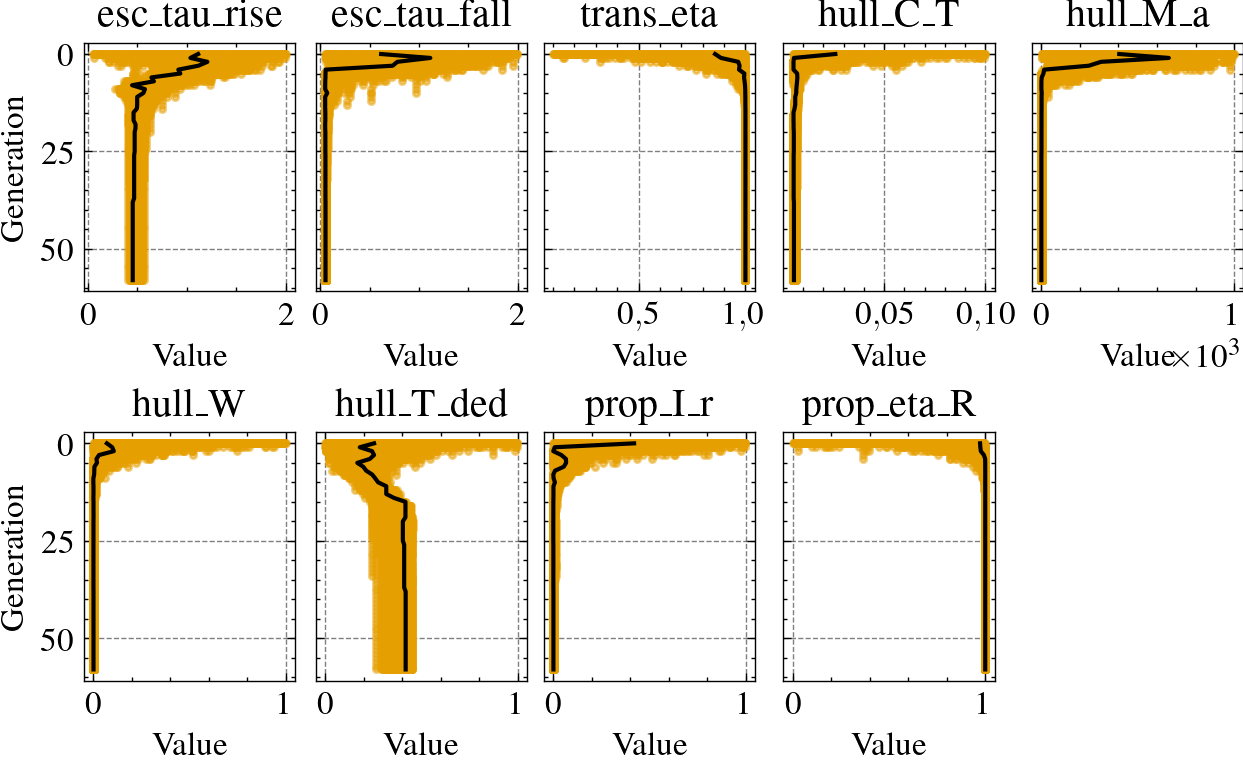

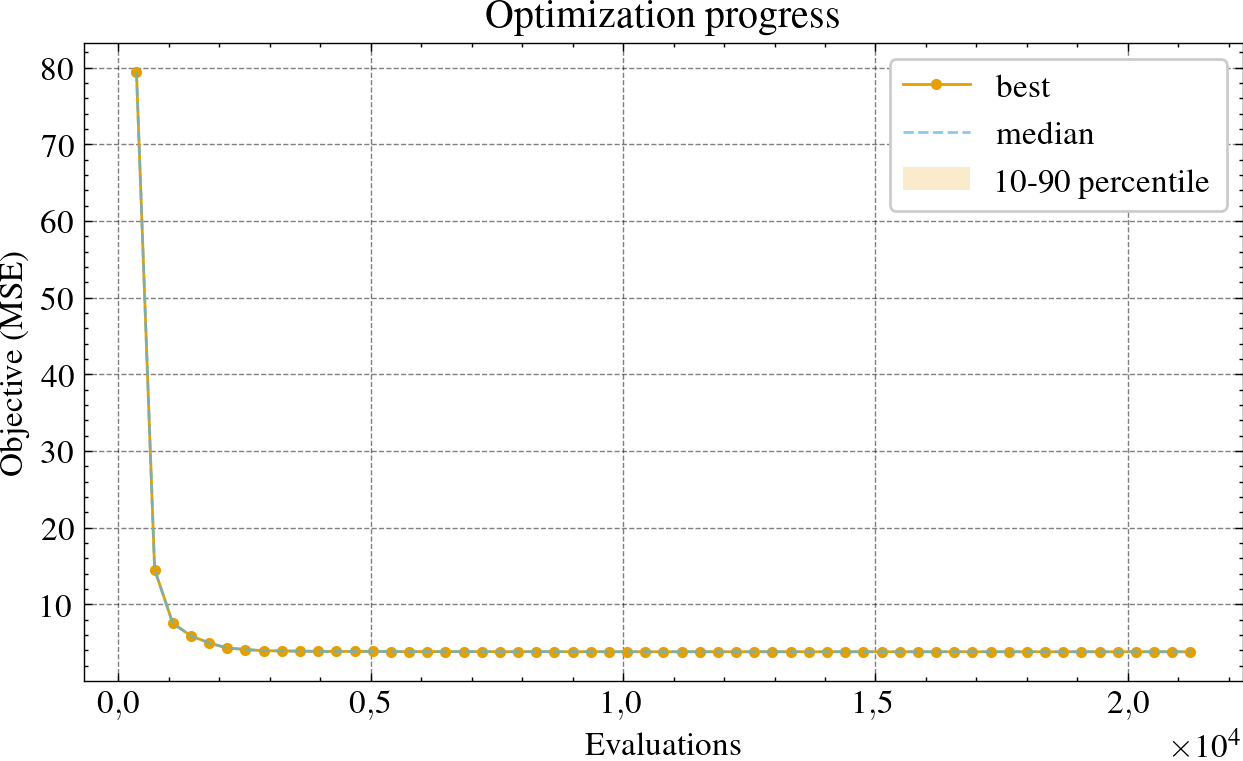

CPU times: user 5.46 s, sys: 2.18 s, total: 7.64 s
Wall time: 2min 10s


In [11]:
%%time
## PROPULSION OPTIMIZATION

def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Propulsion.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()

# Select the optimization data
data_cols = ['motor_w', 'esc_i_in', 'hull_u']
input_cols = ['batt_v', 'pilot_d']

# Put simulation data into df
df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols]
# df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols][130:] # This reduced section also works well

# Set model states initial conditions
input_initial_state = {}

# Initialize Parameters
params_bounds, _ = build_params_bounds()

# Initialize the thread pool and create the runner
n_processes = 32
pool = Pool(processes=n_processes)
runner = StarmapParallelization(pool.starmap)

try:
    # Initialize the problem
    model = Propulsion
    model_params = propulsion_params
    constraint_funcs = make_constraints(model, model_params, params_bounds)
    problem = MyOptimizationProblem(
        model=model,
        model_function=model_function,
        training_data=df_train,
        training_data_columns=data_cols,
        model_params=model_params,
        opt_params_bounds=params_bounds,
        input_initial_state=input_initial_state,
        input_columns=input_cols,
        data_scaler=RobustScaler,
        # data_scaler=StandardScaler,
        elementwise_runner=runner,
        constraint_funcs=constraint_funcs,
        # print_exceptions=True,
    )

    algorithm = DE(
        # pop_size=100*len(params_bounds),
        pop_size=40*len(params_bounds),
        sampling=LHS(),
        # variant="DE/rand/1/bin",
        variant="DE/best/1/bin",
        F=0.5,
        CR=0.9,
        dither='vector',
    )

    # Specify termination criteria
    termination = DefaultSingleObjectiveTermination(
        xtol=1e-8,
        cvtol=1e-6,
        ftol=1e-6,
        period=20,
        # period=100,
        n_max_gen=1000,
        n_max_evals=1000000
    )

    # Run the optimization
    result = minimize(
        problem,
        algorithm,
        termination=termination,
        seed=42,
        verbose=True,
        save_history=True,
    )
    print('Threads:', result.exec_time)
finally:
    pool.close()
    pool.join()

# Print the results
best_params = convert_to_model_params({k: result.X[i] for (i, k) in enumerate(params_bounds.keys())})
original_params = {k: convert_to_model_params(model_params)[k] for k in best_params.keys()}
print("Original parameters were:")
display(original_params)
print("Best parameters found:")
display(best_params)
print("Objective value at solution:", result.F)

plot_optimization_params(result, params_bounds)
plot_optimization_error(result, params_bounds)

T = np.ascontiguousarray(df_train['t'].to_numpy())
U = np.ascontiguousarray(df_train[input_cols].to_numpy().T)
X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params | best_params)

best_fit_data = model_function(T, U, X0, **(model_params | best_params))

# for col in data_cols:
#     plot_compare(df_train, best_fit_data, col)


In [12]:
params_output_path = 'propulsion_params.json'
save_model_params_to_json(params_output_path, propulsion_params | best_params)
model_params = load_model_params_from_json(params_output_path)
model_params

{'esc_E_off': 0.00011,
 'esc_E_on': 7e-05,
 'esc_F_s': 12550,
 'esc_Q_rr': 1.9e-07,
 'esc_R_ds_on': 0.008256754167097705,
 'esc_V_F': 3.338359854985,
 'esc_V_ds_ov': 2.0,
 'esc_r_D': 0.004027165799996619,
 'esc_tau_fall': 0.05382311411057277,
 'esc_tau_rise': 0.45185746234392316,
 'hull_C_T': 0.005448399998501737,
 'hull_M': 293.7,
 'hull_M_a': 0.15195016919075136,
 'hull_S_air': 4.188174709710495,
 'hull_S_water': 4.050226176680205,
 'hull_T_ded': 0.4184892215005117,
 'hull_W': 0.0007050254981052087,
 'motor_B': 0.0012793008044770459,
 'motor_I_r': 0.011828773027862982,
 'motor_I_r_load': 0,
 'motor_K_Q': 0.10543193741528227,
 'motor_K_V': 0.10337093946599393,
 'motor_L_A': 6.336356266841513e-05,
 'motor_R_A': 0.019579524515654242,
 'prop_D': 0.2286,
 'prop_I_r': 0.0009628344536782173,
 'prop_eta_R': 0.9999703722115555,
 'prop_k_Q_coeffs': array([ 0.05473053, -0.01755624, -0.00053339, -0.01076869]),
 'prop_k_T_coeffs': array([ 0.3721783 , -0.10836846, -0.16738142,  0.028249  ]),
 'rho

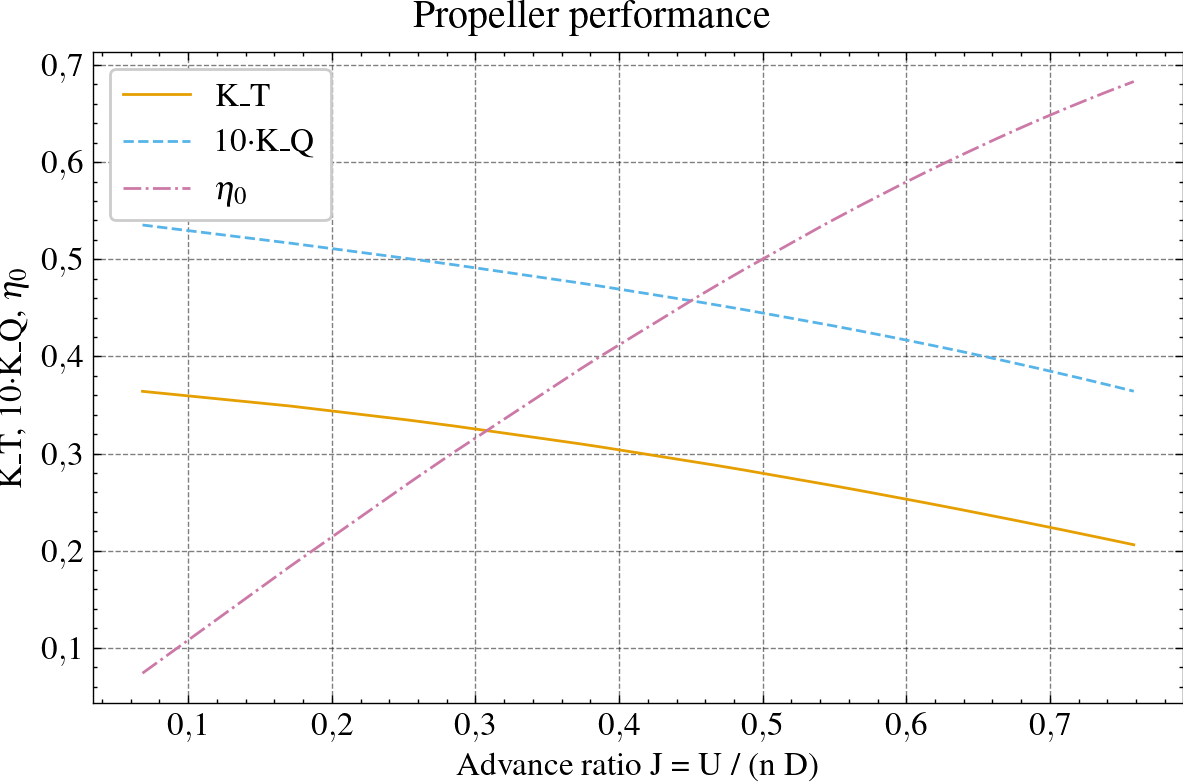

In [13]:
# Check Propeller curve
def filter_prop_p_outints(df, params):
    df = df.copy()

    prop_D     = params["prop_D"]
    rho_water  = params["rho_water"]
    hull_W  = params["hull_W"]
    trans_k = params['trans_k']

    # Kinematics
    prop_w = df["motor_w"] * trans_k
    df["prop_n"] = prop_w / (2*np.pi)                       # [rev/s]
    df["u_rel"]  = (1.0 - hull_W) * df["hull_u"]               # inflow at prop
    df["J"]      = df["u_rel"] / (df["prop_n"] * prop_D)

    # Basic operating filters
    m = (
        (df["prop_n"].abs() > 1)      # ~>12 rpm
        & (df["u_rel"] > 0.1)           # avoid U≈0
        & (df["prop_t"] > 1.0)          # avoid almost-zero thrust
        & (df["prop_q"] > 0.05)         # positive, non-trivial torque
        & (df["J"] > 0)
        & np.isfinite(df["J"])
    )
    df = df[m].copy()

    # Dimensionless coefficients
    df["K_T"] = df["prop_t"] / (rho_water * df["prop_n"]**2 * prop_D**4)
    df["K_Q"] = df["prop_q"] / (rho_water * df["prop_n"]**2 * prop_D**5)

    # Efficiency
    df["eta0"] = df["J"] * df["K_T"] / (2*np.pi * df["K_Q"])

    # Filter absurd efficiencies and J outliers
    m_eta = (
        (df["eta0"] > 0.0) & (df["eta0"] < 1) &
        (df["J"] < 1.5)
    )
    df = df[m_eta].copy()
    return df

df_prop = filter_prop_p_outints(best_fit_data, model_params).sort_values("J")

fig, ax1 = plt.subplots(figsize=(6, 4))

ax1.plot(df_prop["J"], df_prop["K_T"], label="K_T")
ax1.plot(df_prop["J"], 10.0 * df_prop["K_Q"], label="10·K_Q")
ax1.plot(df_prop["J"], df_prop["eta0"], label=r'$\eta_0$')
ax1.set_xlabel("Advance ratio J = U / (n D)")
ax1.set_ylabel(r'K_T, 10·K_Q, $\eta_0$')
ax1.grid(True)

ax1.legend(loc="best")
plt.suptitle('Propeller performance')
plt.show()


In [14]:
test_section = test_sections[0]

df_test = df.loc[(df.index >= test_section['start']) & (df.index <= test_section['end']), ['t'] + data_cols + input_cols]

T = df_test['t'].to_numpy()
U = df_test[input_cols].to_numpy().T
X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params)

df_pred = model_function(T, U, X0, **(model_params))
display(df_pred[['esc_i_in', 'prop_J', 'prop_k_q', 'prop_k_T', 'prop_q', 'prop_t', 'hull_u', 'hull_r']].describe().T[['mean', 'min', 'max']])
# df_pred[['esc_i_in', 'prop_J', 'prop_k_q', 'prop_k_T', 'prop_q', 'prop_t', 'hull_u', 'hull_r']].describe().T[['mean', 'min', 'max']].T.to_dict()

mean       min         max
esc_i_in   32.942179 -5.206822  183.707240
prop_J      0.805535  0.000000    1.500000
prop_k_q    0.033426  0.000000    0.054731
prop_k_T    0.191566  0.000000    0.372178
prop_q      7.568947  0.000000   29.125462
prop_t    188.023024  0.000000  793.465362
hull_u      2.879638  0.000000    5.558117
hull_r    187.775122  0.000000  600.358763

MSE        MAE       RMSE            AE        R2
section data                                                               
D       motor_w    299.641773   8.089514  17.310164 -38574.856469  0.940758
        esc_i_in    31.540265   2.931795   5.616072   1017.322732  0.947781
        hull_u       0.153601   0.254624   0.391920  -1463.911157  0.897125
E       motor_w   1408.005322  13.127458  37.523397  -5884.328452  0.818146
        esc_i_in   547.672345   5.711741  23.402400  -1159.146728 -0.110083
        hull_u       0.275692   0.247932   0.525064    -76.599074  0.898216
F1      motor_w    866.672650  15.906594  29.439305  -2096.415122  0.895059
        esc_i_in    19.723054   2.489281   4.441065   -337.525466  0.991073
        hull_u       0.416375   0.385575   0.645271    -70.705698  0.835171
F2      motor_w    447.658125  12.789784  21.157933  -3010.149762  0.940021
        esc_i_in    73.206821   3.697529   8.556098    277.761607  0.952519
        hull_u       0.331738   0.415242   0.575967   -111.018212  0.857039

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_motor_w_test_d.pdf


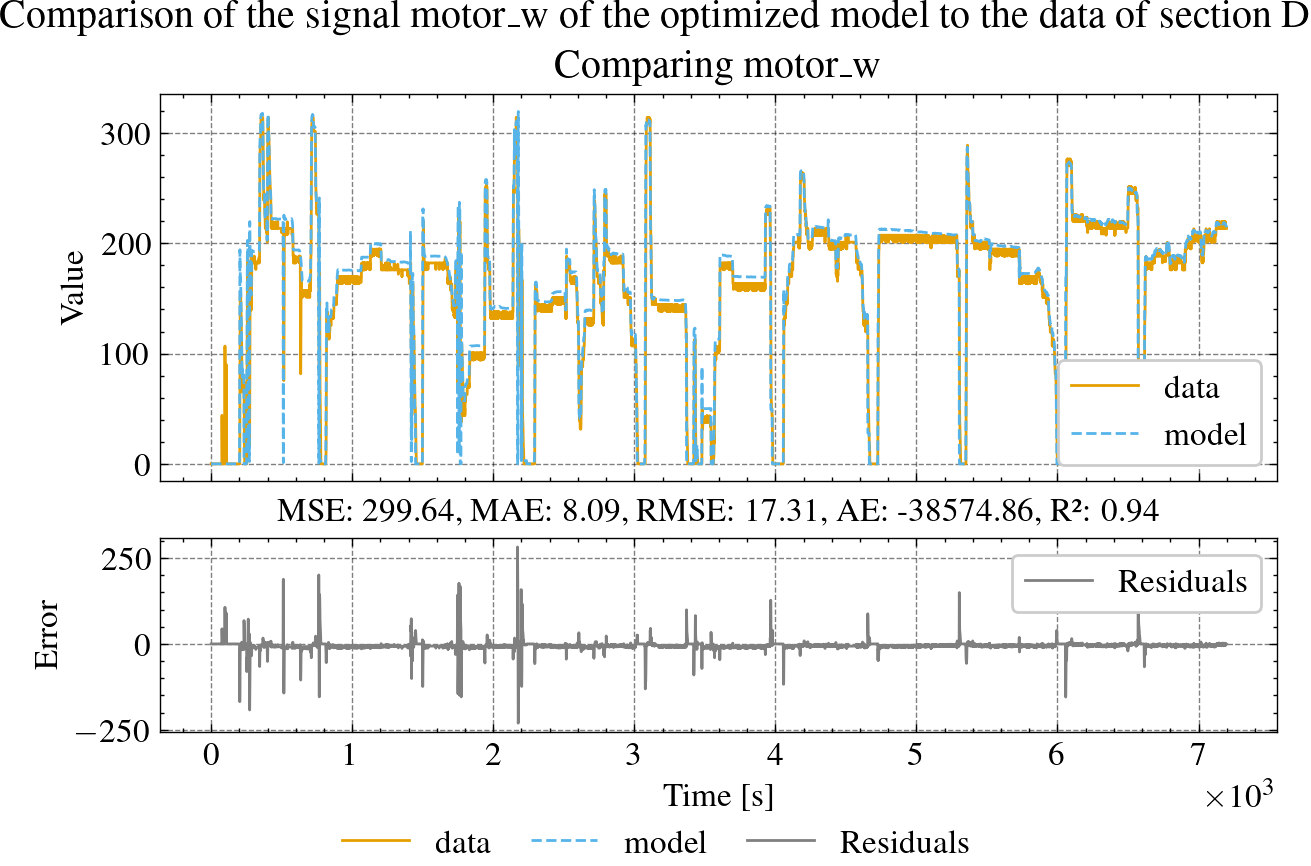

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_esc_i_in_test_d.pdf


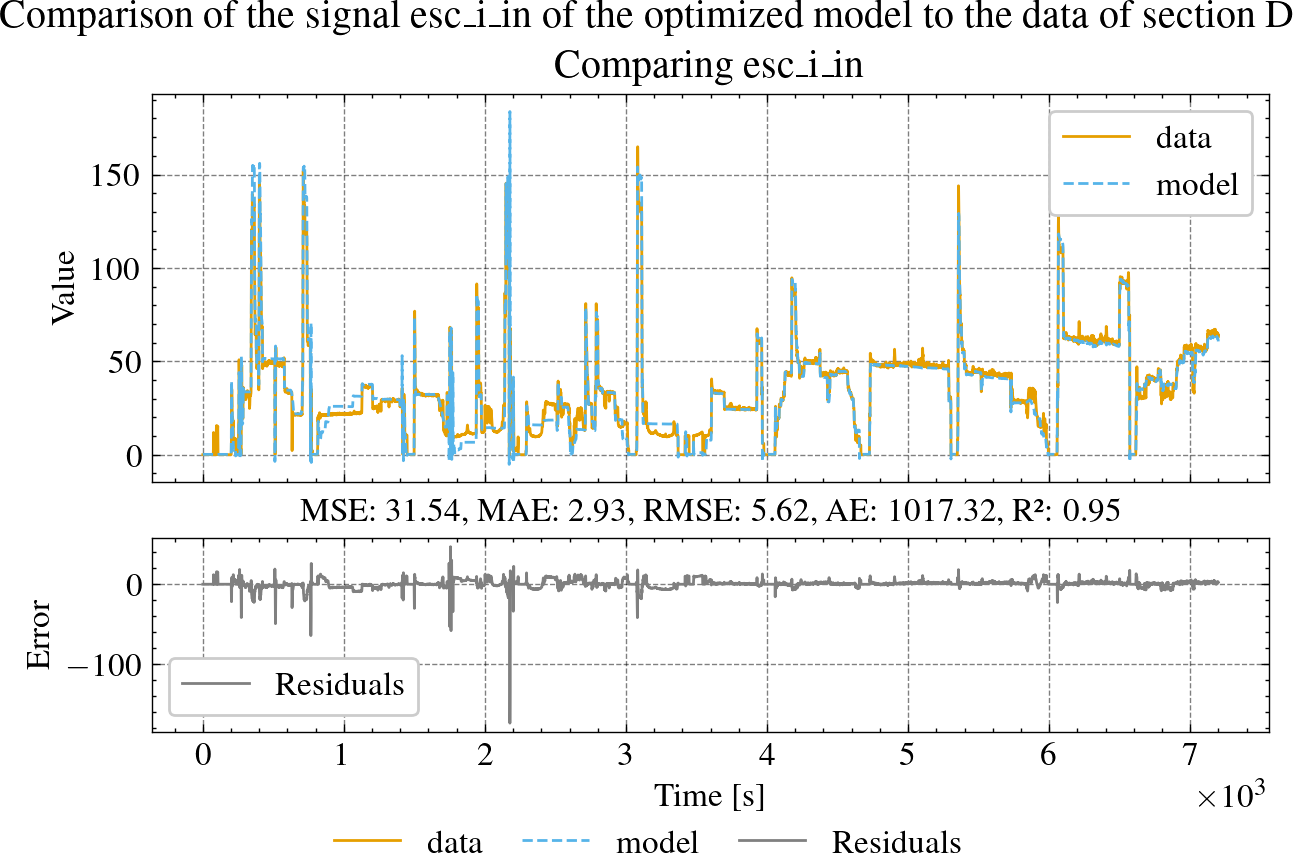

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_hull_u_test_d.pdf


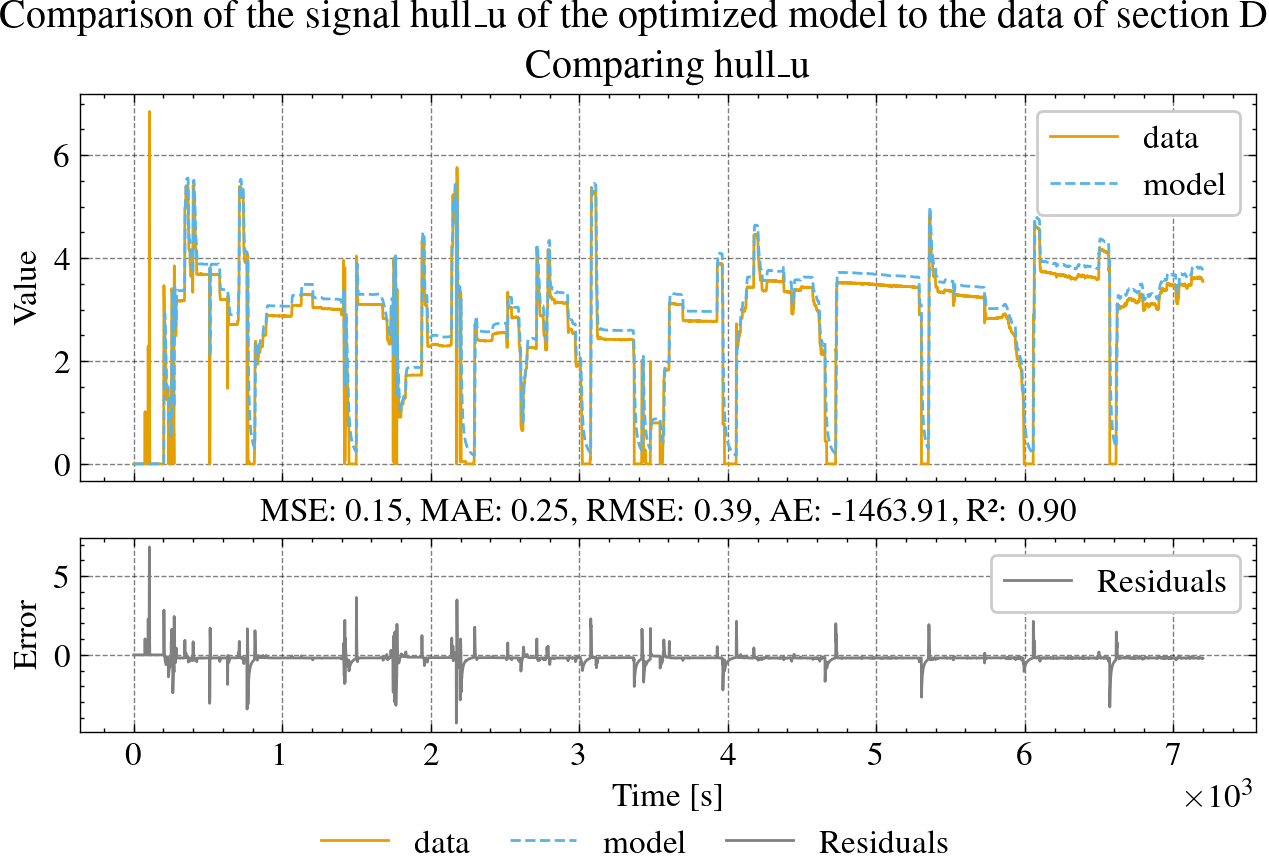

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_motor_w_test_e.pdf


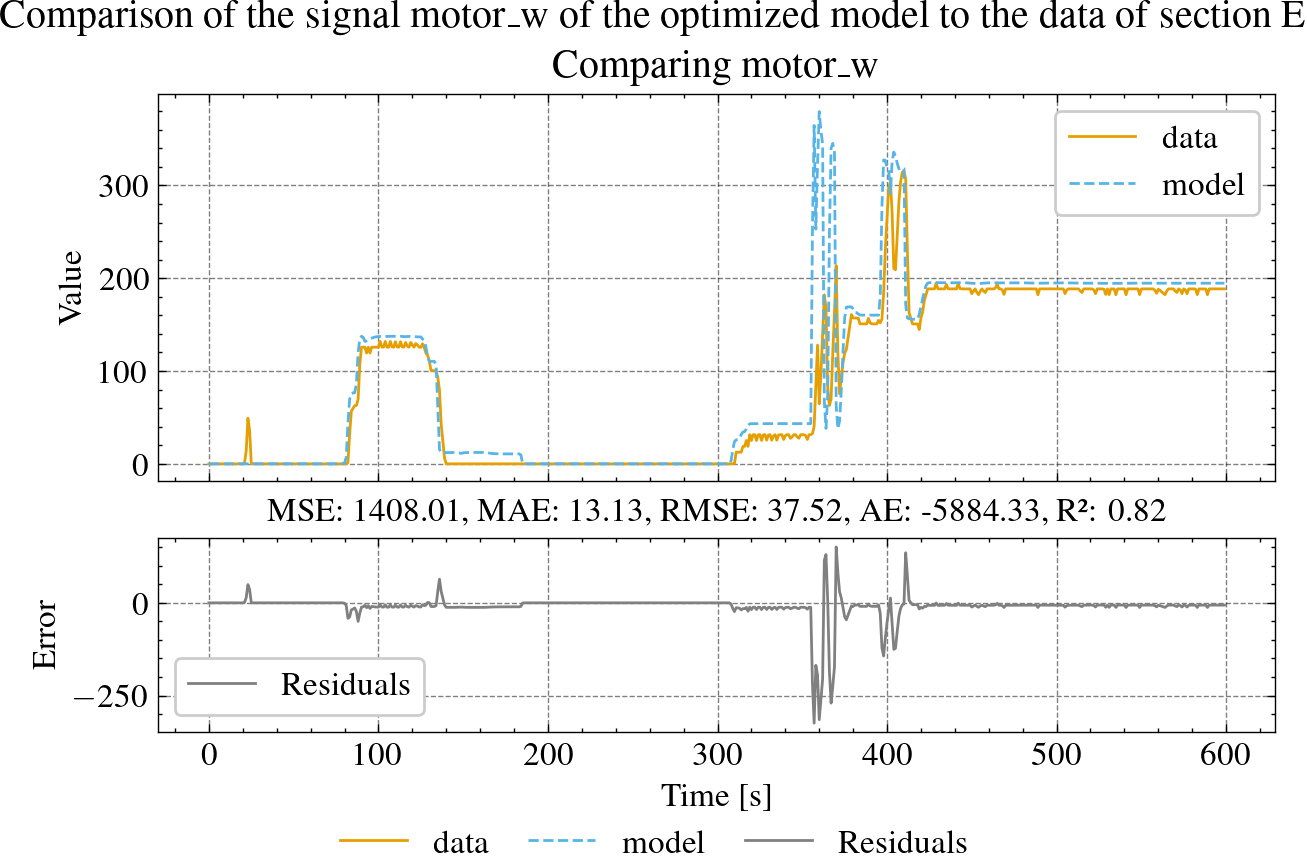

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_esc_i_in_test_e.pdf


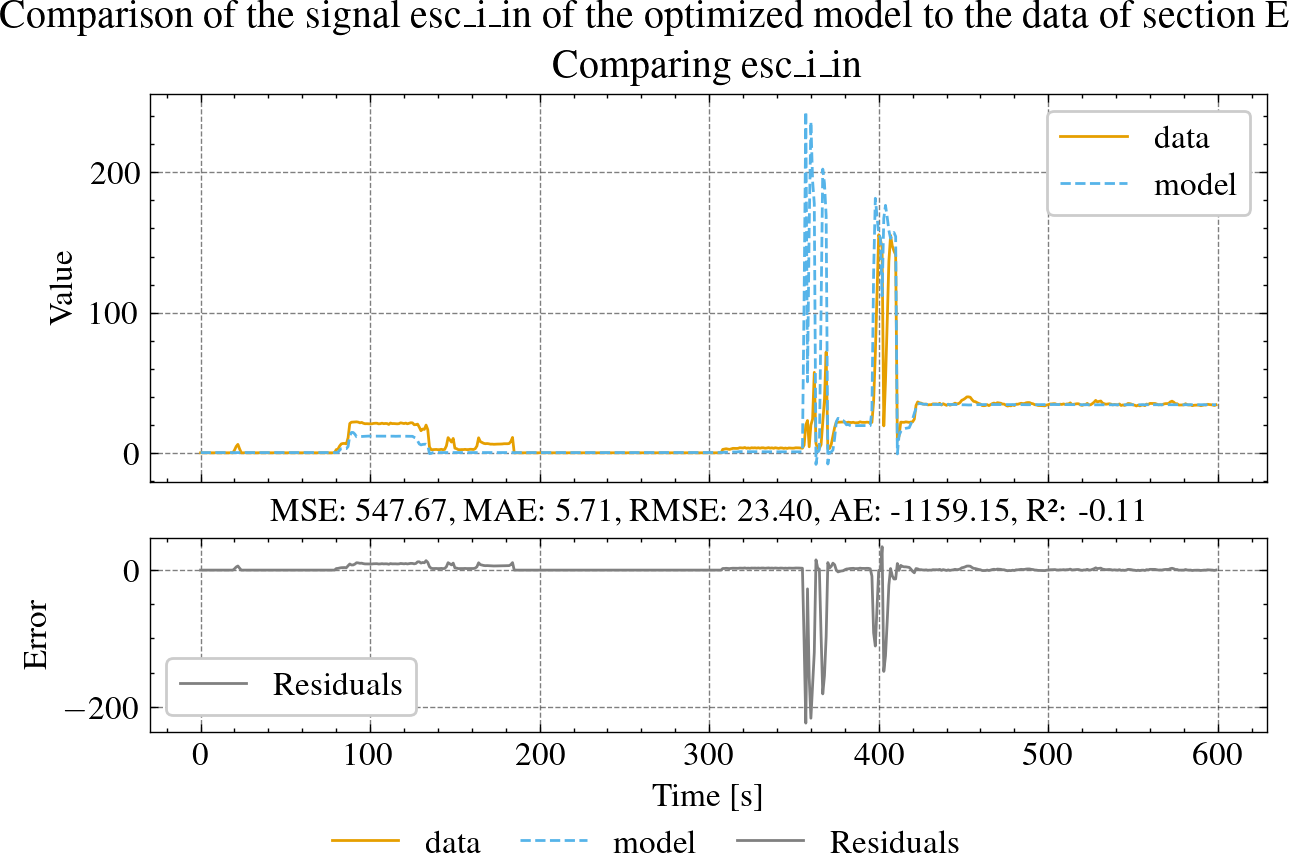

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_hull_u_test_e.pdf


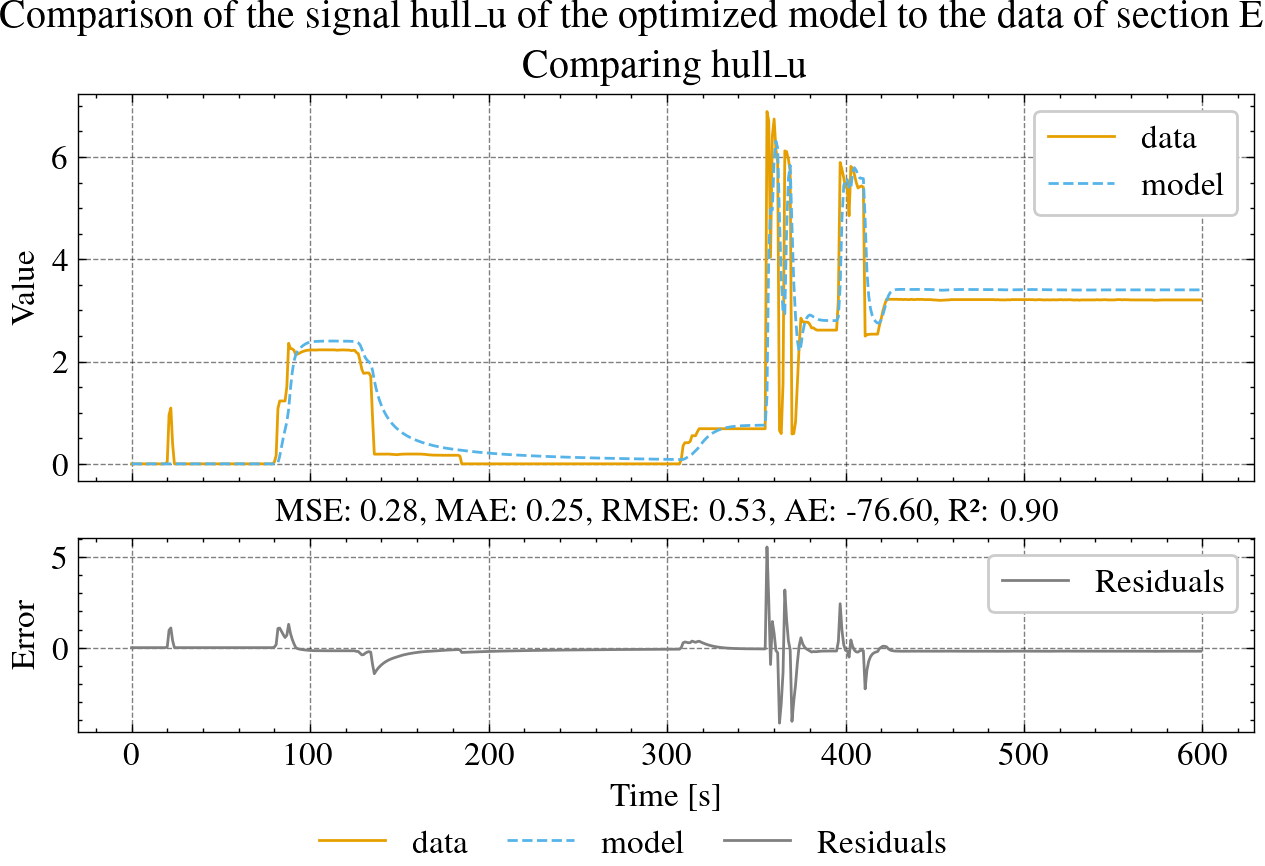

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_motor_w_test_f1.pdf


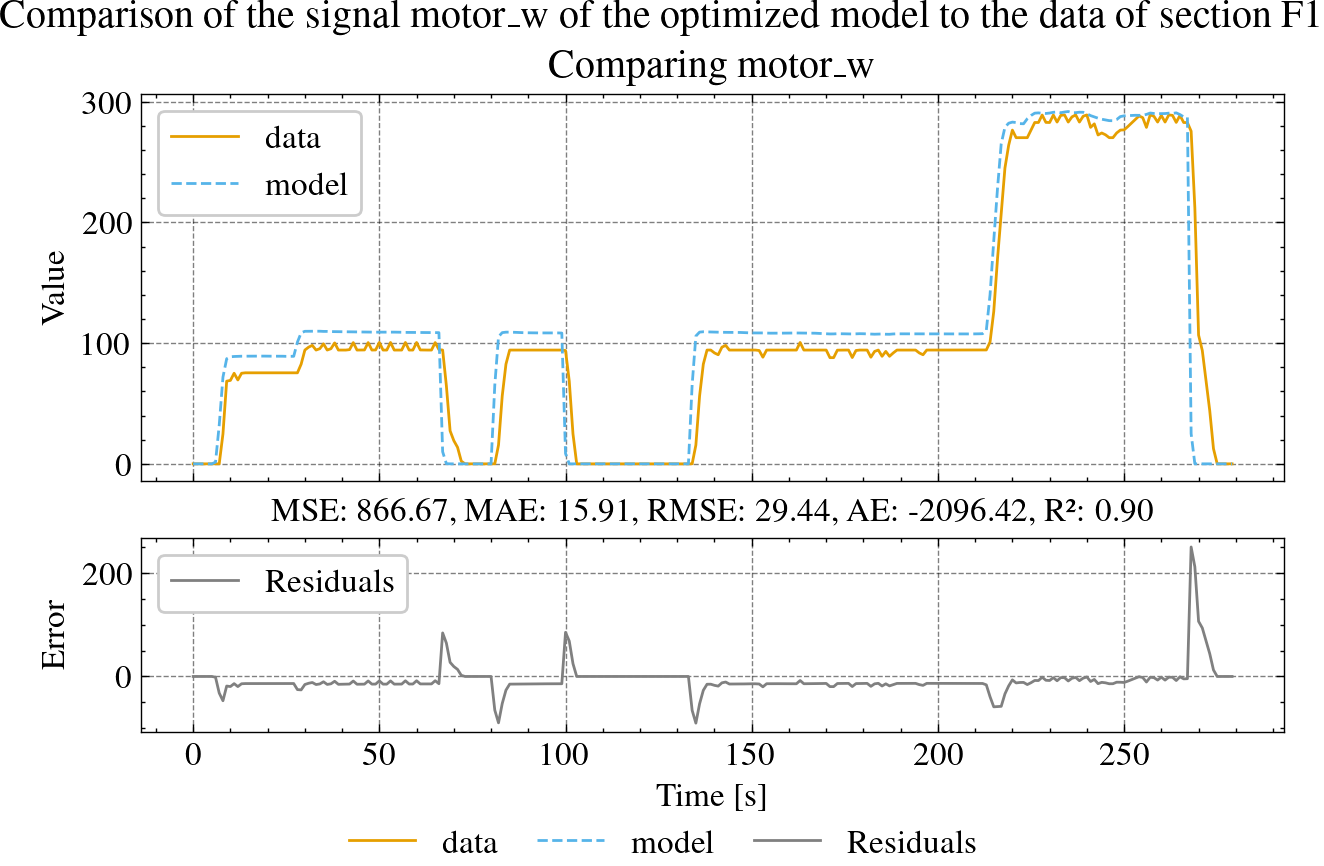

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_esc_i_in_test_f1.pdf


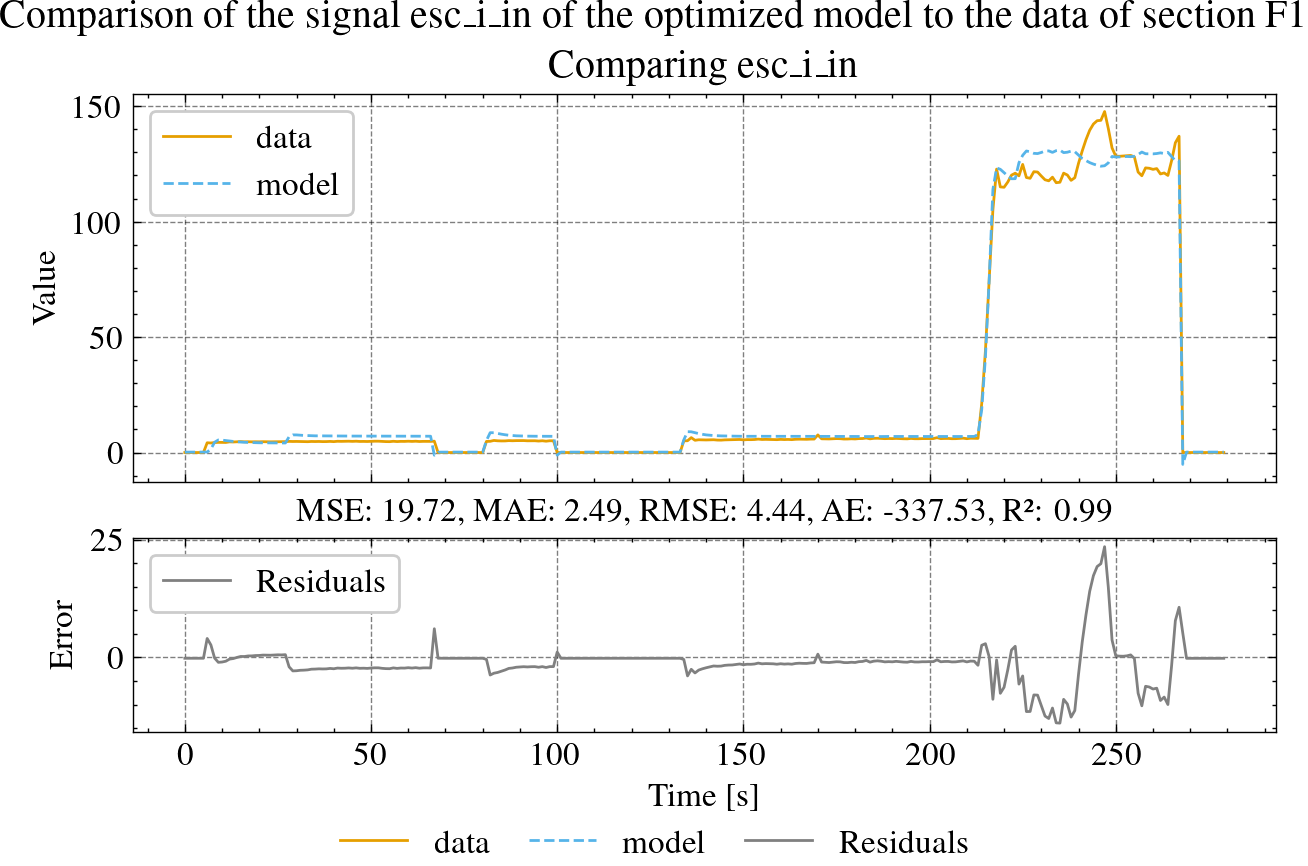

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_hull_u_test_f1.pdf


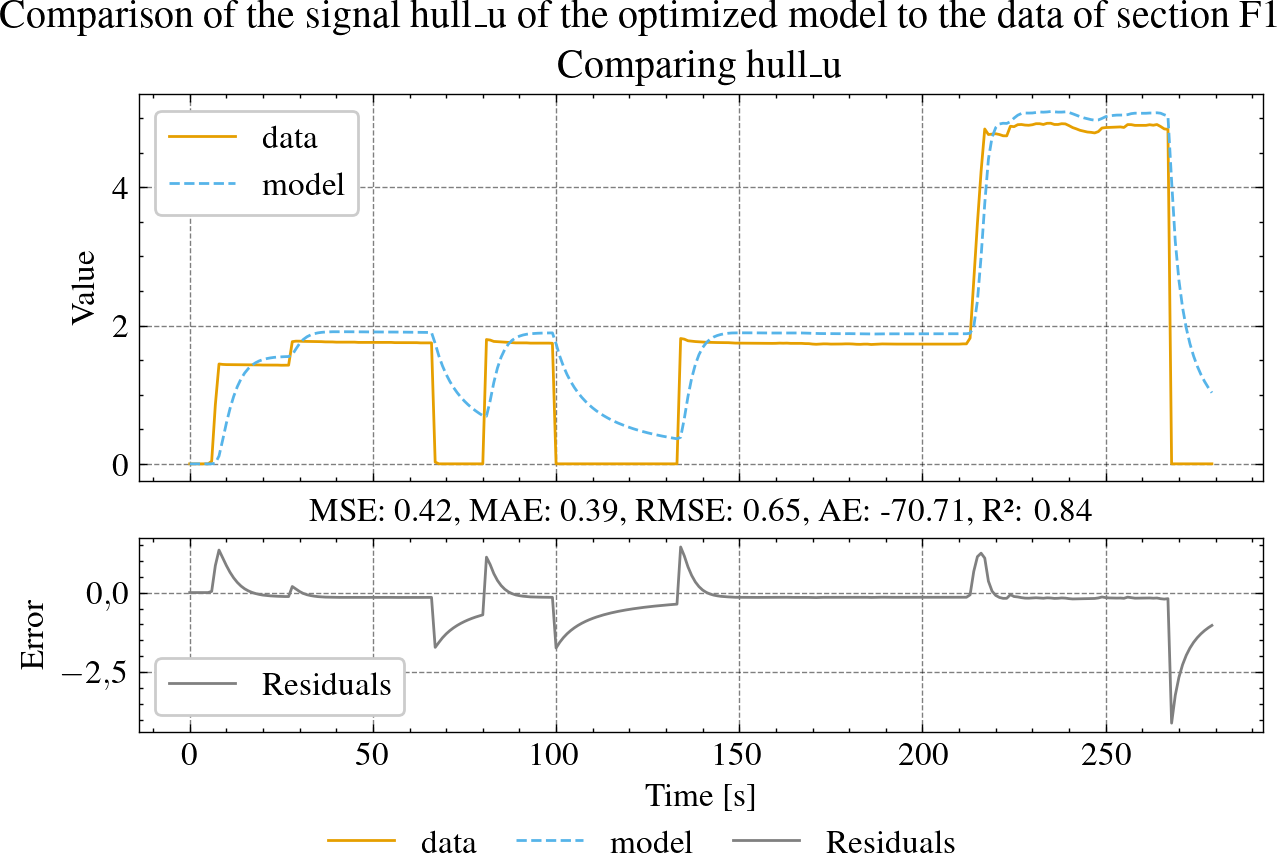

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_motor_w_test_f2.pdf


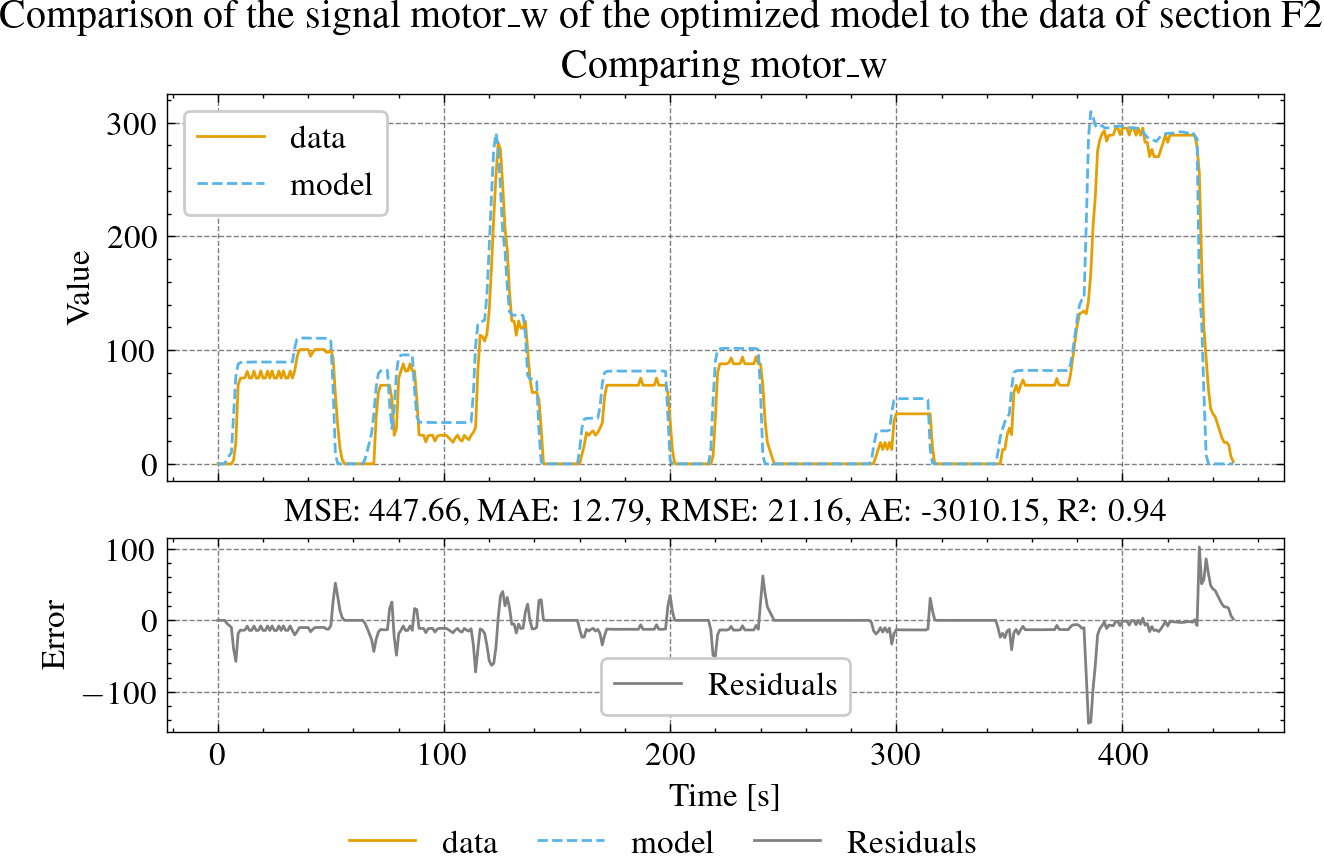

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_esc_i_in_test_f2.pdf


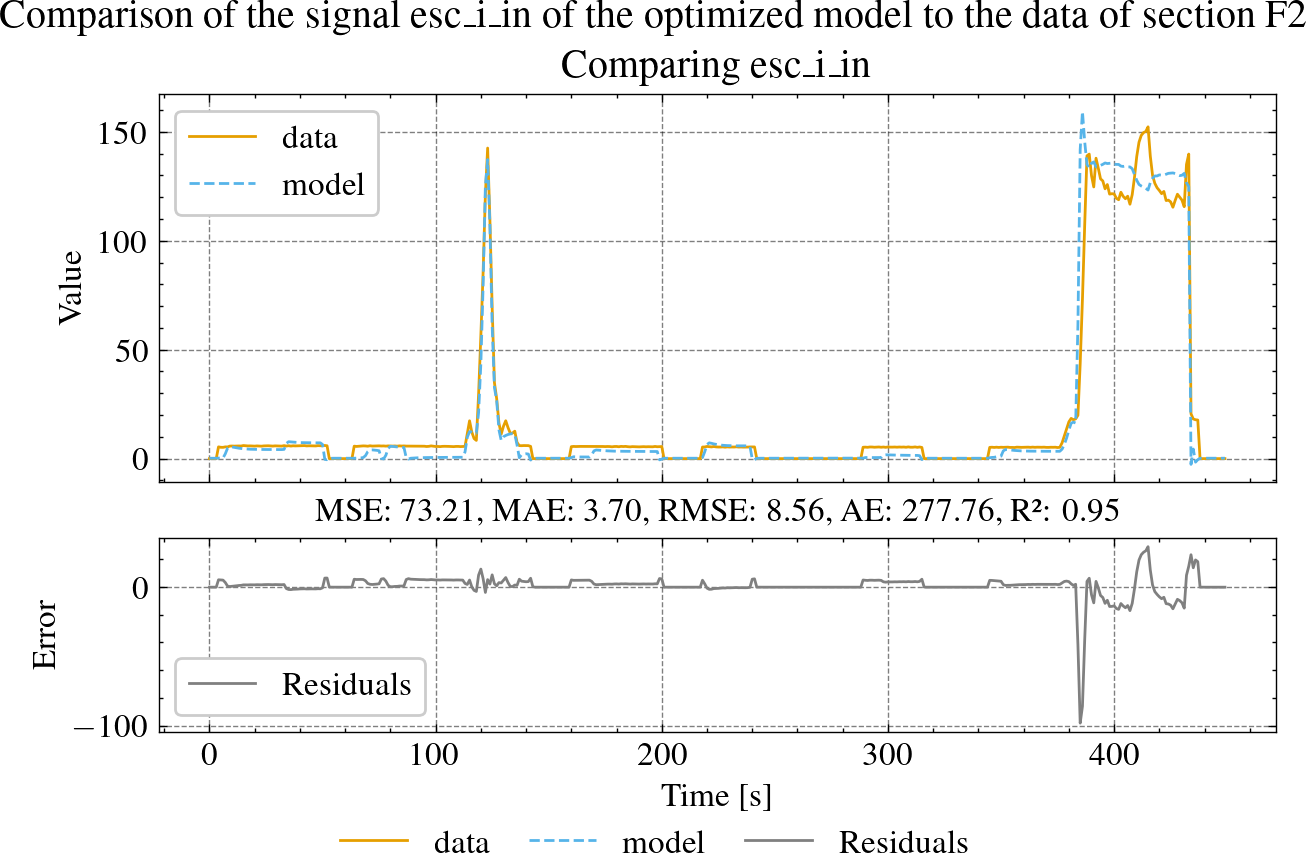

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//propulsion_optimization_test_residuals_hull_u_test_f2.pdf


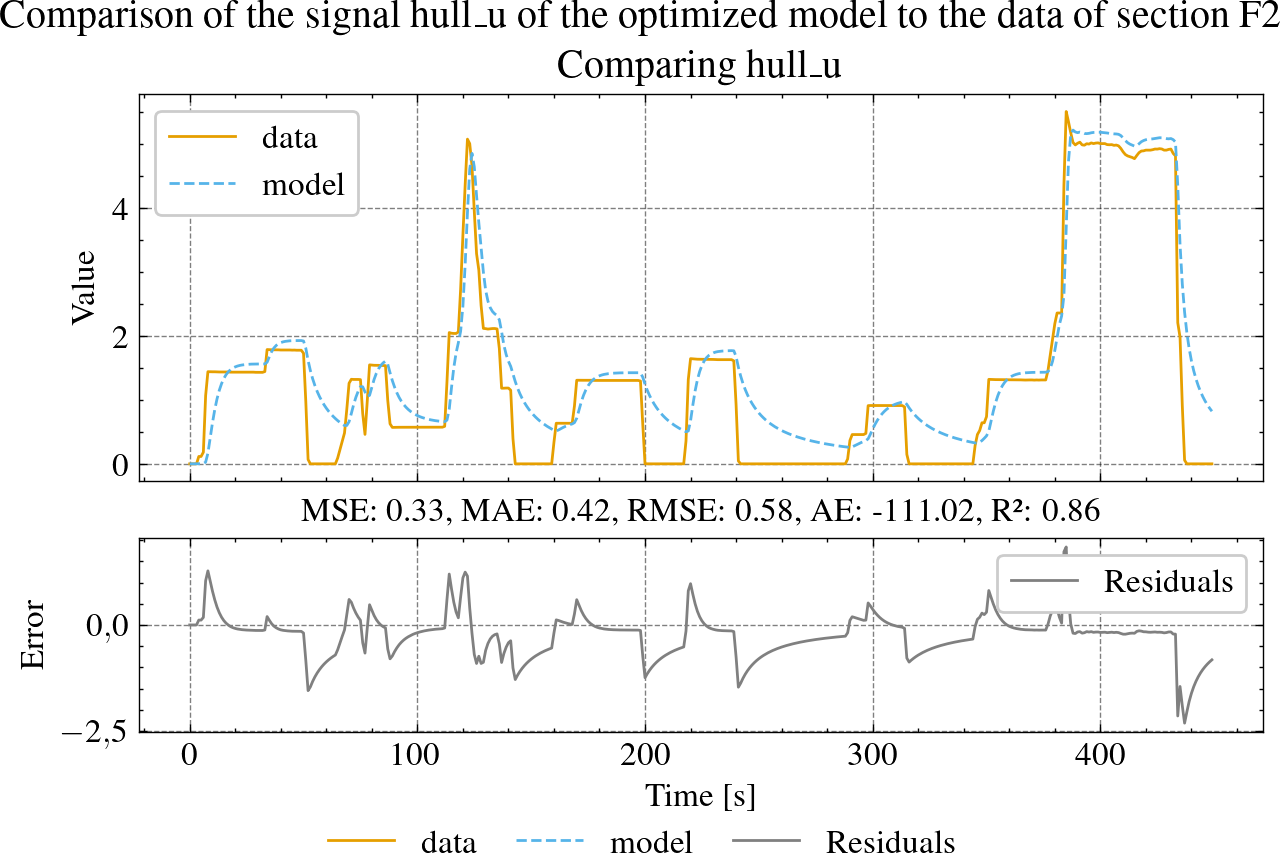

In [15]:
# Initialize a list to store metrics
metrics_list = []
for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')

    # Select the data and simulate
    df_test = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols].dropna()
    if df_test.size == 0:
        print('Ignoring section', section_name, ' because of insufficient size')
        continue

    # Simulate
    T = df_test['t'].to_numpy()
    U = df_test[input_cols].to_numpy().T
    X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params)

    df_pred = model_function(T, U, X0, **(model_params))

    # Compute metrics for each data column
    for col in data_cols:
        metrics = compute_metrics(df_test[col].to_numpy(), df_pred[col].to_numpy())
        metrics['section'] = section_name
        metrics['data'] = col

        metrics_list.append(metrics)

# Create a DataFrame from the metrics list
df_metrics = pd.DataFrame(metrics_list).drop(columns=['residuals']).set_index(['section', 'data'])
display(df_metrics)

metrics_table_latex = df_metrics.to_latex(
    index=True,
    caption="Métricas de avaliação do modelo da Geração",
    label="table:propulsion_optimization_metrics_table",
    float_format="%.2f",
    column_format="l|l" + "|c" * (len(df_metrics.columns)),
    escape=True,
    decimal=',',
    position='h!',
    multicolumn=True,
).replace('\\toprule', '\\hline').replace('\\bottomrule\n', '').replace('\\midrule', '\\hline').replace('\\end{table}', '\\fonte{Elaboração Própria (\\the\\year)}\n\\end{table}')

with open(f"{latex_tex_path}/propulsion_optimization_metrics_table.tex", "w") as f:
    f.write(metrics_table_latex)

for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')

    df_test = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols].dropna()
    if df_test.size == 0:
        print('Ignoring section', section_name, ' because of insufficient size')
        continue

    # Simulate
    T = df_test['t'].to_numpy()
    U = df_test[input_cols].to_numpy().T
    X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params)

    df_pred = model_function(T, U, X0, **(model_params))

    # Plot comparison for each data column
    for col in data_cols:
        filename = f'{latex_img_path}/propulsion_optimization_test_residuals_{col}_test_{section_name.lower()}.pdf'
        print(filename)
        fig_save_and_show(
            filename=filename,
            show_title=f'Comparison of the signal {col} of the optimized model to the data of section {section_name}',
            save_title=f'Comparação do sinal {col} do modelo otimizado com os dados da seção {section_name}',
            ncol=3,
            fig=plot_compare(df_test, df_pred, col, show=False),
        )


In [16]:
# # Plot the original data and the fitted curve
# fig_save_and_show(
#     filename=f'{latex_img_path}/propulsion_optimization_params.pdf',
#     show_title='propulsion optimum parameters evolution at each propulsion',
#     save_title='Evolução dos parâmetros ótimos do modelo da Propulsão à cada geração',
#     ncol=2,
#     fig=plot_optimization_params(result, params_bounds=params_bounds, scatter_alpha=0.5, scatter_size=1, max_columns=4, show=False)
# )

# fig_save_and_show(
#     filename=f'{latex_img_path}/propulsion_optimization_error.pdf',
#     show_title='propulsion optimization error evolution',
#     save_title='Evolução do erro de otimização do modelo da Propulsão',
#     ncol=2,
#     fig=plot_optimization_error(result, show=False),
# )

# for col in data_cols:
#     fig_save_and_show(
#         filename=f'{latex_img_path}/propulsion_optimization_residuals_{col}_train.pdf',
#         show_title=f'Comparison of the signal {col} of the optized model to the train data',
#         save_title=f'Comparação do sinal {col} do modelo otimizado com os dados de treino',
#         ncol=2,
#         fig=plot_compare(df_train, best_fit_data, col, show=False),
#     )

In [17]:
from utils.plot import plot_efficiency_map_scattered
from utils.control import get_steady_state_map

In [18]:
def model_function(T, U, X0, **params) -> pd.DataFrame:
    resp = ct.input_output_response(
        Propulsion.build(params=params),
        T=np.asarray(T, float),
        U=np.asarray(U, float),
        X0=np.asarray(X0, float),
        solve_ivp_method='Radau',
    ).to_pandas()
    
    # Params
    hull_T_ded = params['hull_T_ded']
    hull_W = params['hull_W']

    # Signals
    motor_v = np.asarray(resp['motor_v'], float)
    motor_q_load = np.asarray(resp['motor_q_load'], float)
    motor_i = np.asarray(resp['motor_i'], float)
    motor_w = np.asarray(resp['motor_w'], float)
    esc_i_in =  np.asarray(resp['esc_i_in'], float)
    esc_v_in = np.asarray(resp['batt_v'], float)
    hull_r = np.asarray(resp['hull_r'], float)
    hull_u = np.asarray(resp['hull_u'], float)
    prop_w = np.asarray(resp['prop_w'], float)
    prop_q = np.asarray(resp['prop_q'], float)
    prop_t = np.asarray(resp['prop_t'], float)

    # Motor
    motor_p_in = motor_v * motor_i
    motor_p_out = motor_w * motor_q_load
    motor_eta = np.ma.masked_invalid(motor_p_out / motor_p_in)
    resp['motor_p_in'] = motor_p_in
    resp['motor_p_out'] = motor_p_out
    resp['motor_eta'] = motor_eta

    # ESC
    esc_i_out =  motor_i
    esc_v_out = motor_v
    esc_p_in = esc_i_in * esc_v_in
    esc_p_out = esc_i_out * esc_v_out
    esc_eta = esc_p_out / esc_p_in
    resp['esc_p_in'] = esc_p_in
    resp['esc_p_out'] = esc_p_out
    resp['esc_eta'] = esc_eta

    # Hull
    hull_r_t = hull_r* (1 - hull_T_ded)
    hull_p_out = hull_r_t * hull_u
    hull_t = prop_t
    hull_p_in = hull_t * hull_u
    hull_eta = hull_p_out / hull_p_in
    resp['hull_p_in'] = hull_p_in
    resp['hull_p_out'] = hull_p_out
    resp['hull_eta'] = hull_eta

    # Prop
    prop_p_in = prop_w * prop_q
    prop_u = hull_u * (1 - hull_W)
    prop_p_out = prop_t * prop_u
    prop_eta = prop_p_out / prop_p_in
    resp['prop_p_in'] = prop_p_in
    resp['prop_p_out'] = prop_p_out
    resp['prop_eta'] = prop_eta

    # Trans
    trans_w_in = motor_w
    trans_w_out = prop_w
    trans_q_in = motor_q_load
    trans_q_out = prop_q
    trans_p_in = trans_w_in * trans_q_in
    trans_p_out = trans_w_out * trans_q_out
    trans_eta = trans_p_out / trans_p_in
    resp['trans_p_in'] = trans_p_in
    resp['trans_p_out'] = trans_p_out
    resp['trans_eta'] = trans_eta

    resp['propulsive_eta'] = hull_p_out / esc_p_in
    resp['propulsive_electrical_eta'] = motor_p_out / esc_p_in
    resp['propulsive_mechanical_eta'] = hull_p_out / prop_p_in

    return resp


Y_ss = get_steady_state_map(
    model_class=Propulsion,
    model_function=model_function,
    model_params=model_params,
    sweep_bounds={
        'batt_v': dict(min=36, max=36),
        'pilot_d': dict(min=0, max=1),
    },
    sweep_steps=100,
    dt=1,
    ss_len=10,
    ss_tail_len=2,
)

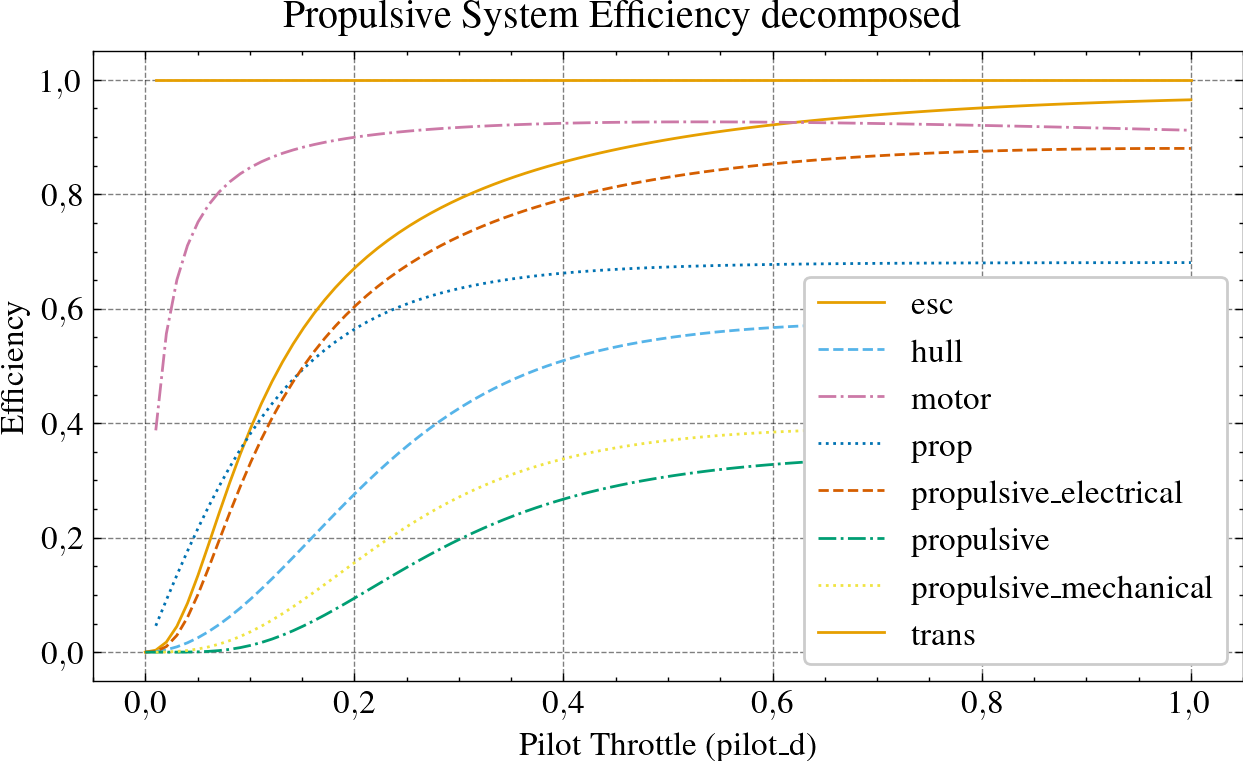

In [19]:
eta_cols = sorted(set([c for c in Y_ss.columns if c.endswith('_eta')]))

Y_ss2 = Y_ss.copy().groupby('pilot_d').mean().reset_index()
for eta_col in eta_cols:
    plt.plot(Y_ss2['pilot_d'], Y_ss2[eta_col], label=eta_col[:-4])

plt.xlabel('Pilot Throttle (pilot_d)')
plt.ylabel('Efficiency')
plt.suptitle('Propulsive System Efficiency decomposed')
plt.legend()
plt.show()

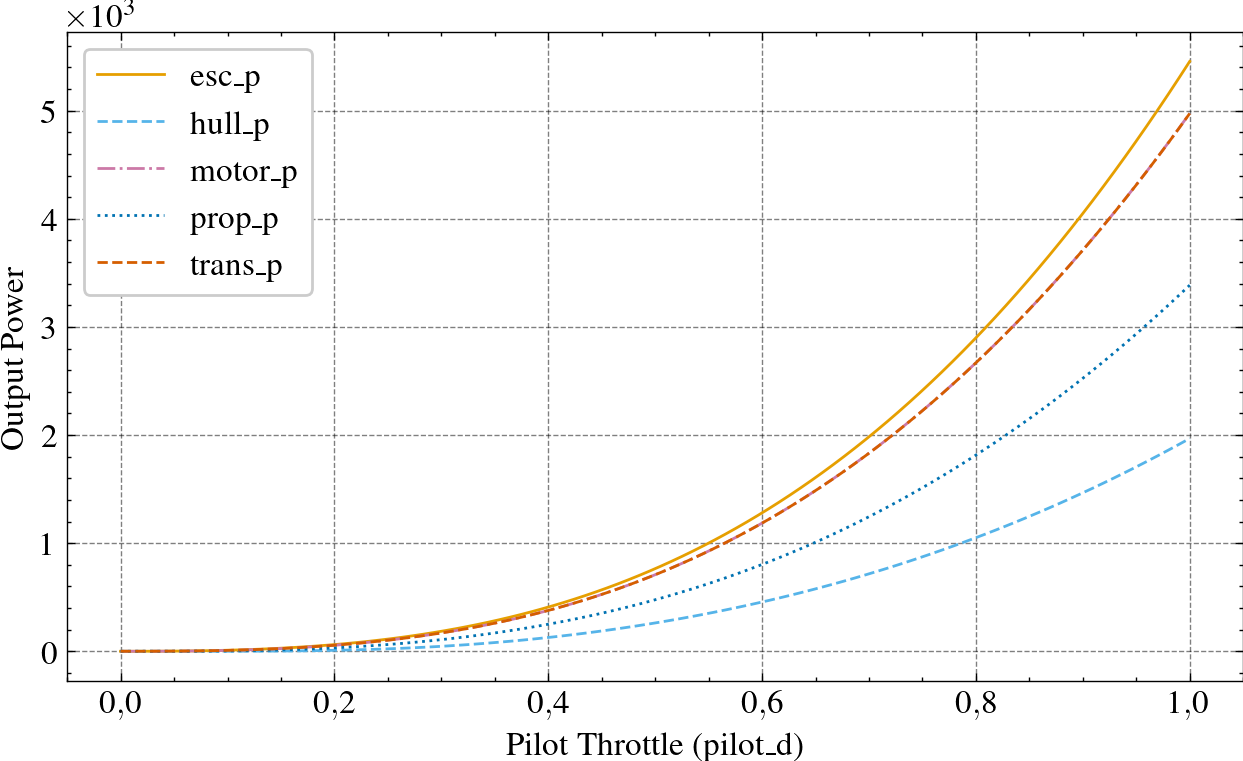

In [20]:
p_out_cols = sorted(set([c for c in Y_ss.columns if c.endswith('_p_out')]))

Y_ss2 = Y_ss.copy().groupby('pilot_d').mean().reset_index()
for p_out_col in sorted(p_out_cols):
    plt.plot(Y_ss2['pilot_d'], Y_ss2[p_out_col], label=p_out_col[:-4])

plt.xlabel('Pilot Throttle (pilot_d)')
plt.ylabel('Output Power')
plt.legend()
plt.show()


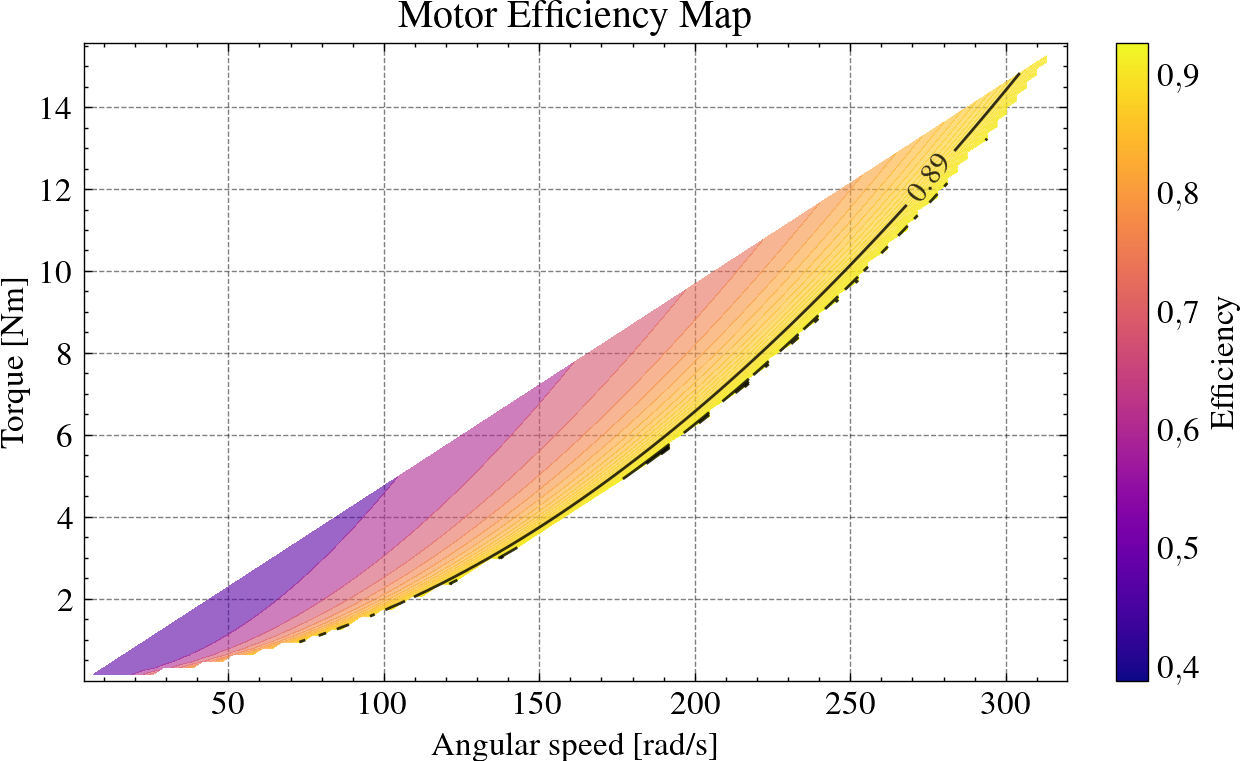

In [21]:
fig, ax, out = plot_efficiency_map_scattered(
    Y_ss,
    x='motor_w', y='motor_q_load', z='motor_eta',
    nx=100, ny=100,
    mask_col='motor_p_out', mask_min=0,
    level_pmin=0, level_pmax=100, level_n=100,
    contour_lines=True,
    line_pmin=0, line_pmax=95, line_n=7,
    line_colors='k',
    label_lines=1,
    title='Motor Efficiency Map',
    xlabel='Angular speed [rad/s]',
    ylabel='Torque [Nm]',
    cbar_label='Efficiency',
    cmap='plasma',
    fill_alpha=0.6,
)
plt.show()

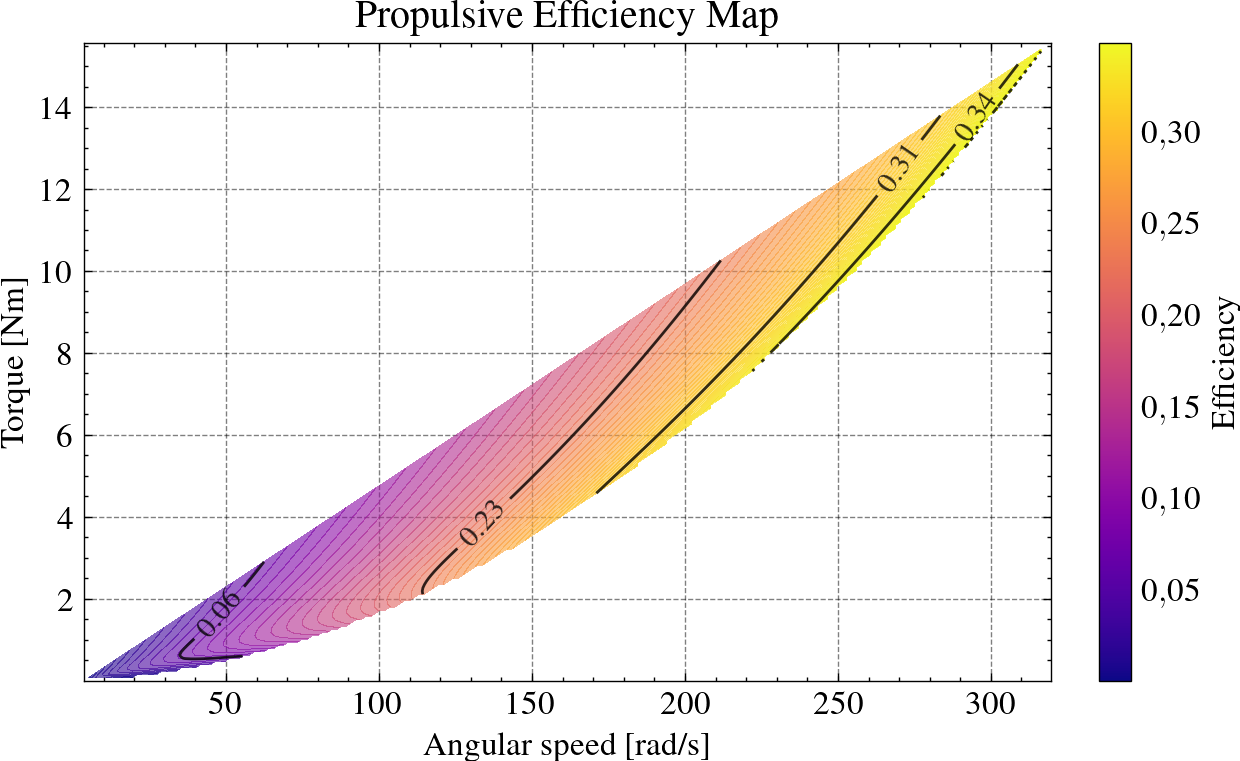

In [22]:
fig, ax, out = plot_efficiency_map_scattered(
    Y_ss,
    x='motor_w', y='motor_q_load', z='propulsive_eta',
    nx=200, ny=200,
    mask_col='motor_p_out', mask_min=0,
    level_pmin=0, level_pmax=100, level_n=100,
    contour_lines=True,
    line_pmin=0, line_pmax=100, line_n=7,
    line_colors='k',
    label_lines=1,
    title='Propulsive Efficiency Map',
    xlabel='Angular speed [rad/s]',
    ylabel='Torque [Nm]',
    cbar_label='Efficiency',
    cmap='plasma',
    fill_alpha=0.6,
)
plt.show()

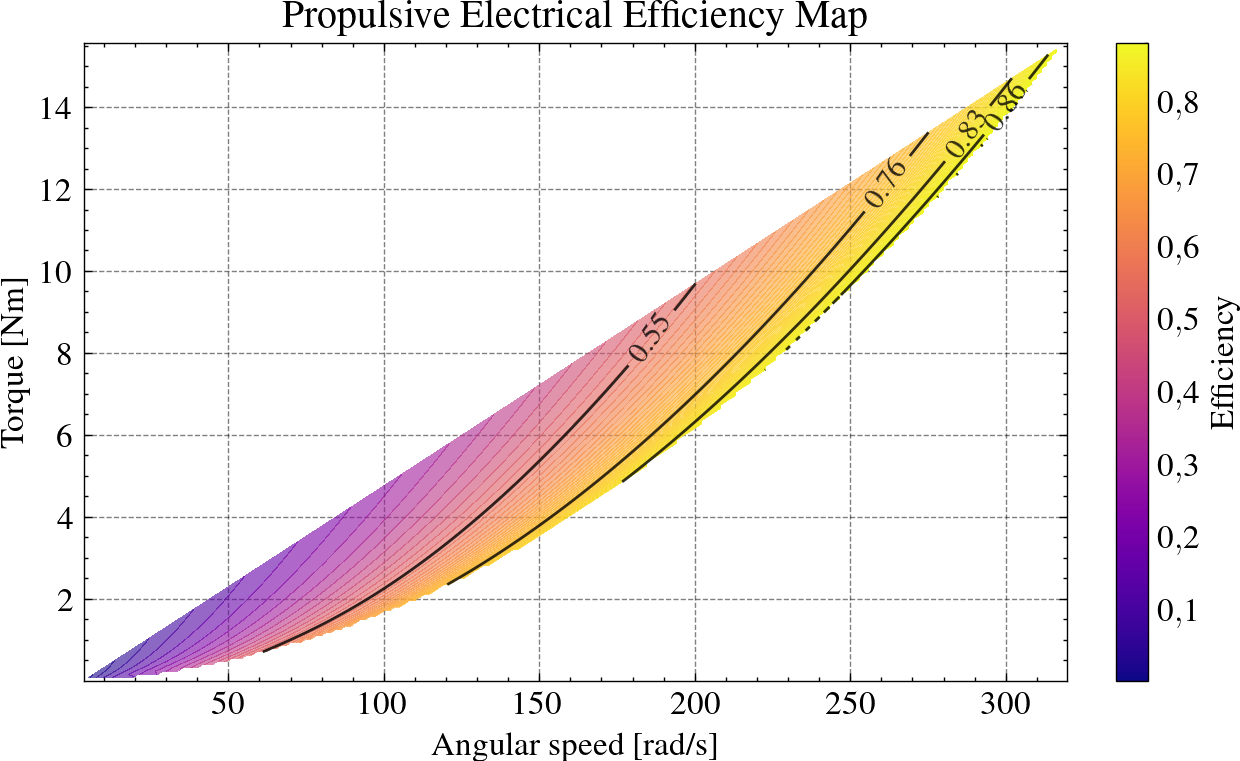

In [23]:
fig, ax, out = plot_efficiency_map_scattered(
    Y_ss,
    x='motor_w', y='motor_q_load', z='propulsive_electrical_eta',
    nx=200, ny=200,
    mask_col='motor_p_out', mask_min=0,
    level_pmin=0, level_pmax=100, level_n=100,
    contour_lines=True,
    line_pmin=0, line_pmax=100, line_n=7,
    line_colors='k',
    label_lines=1,
    title='Propulsive Electrical Efficiency Map',
    xlabel='Angular speed [rad/s]',
    ylabel='Torque [Nm]',
    cbar_label='Efficiency',
    cmap='plasma',
    fill_alpha=0.6,
)
plt.show()

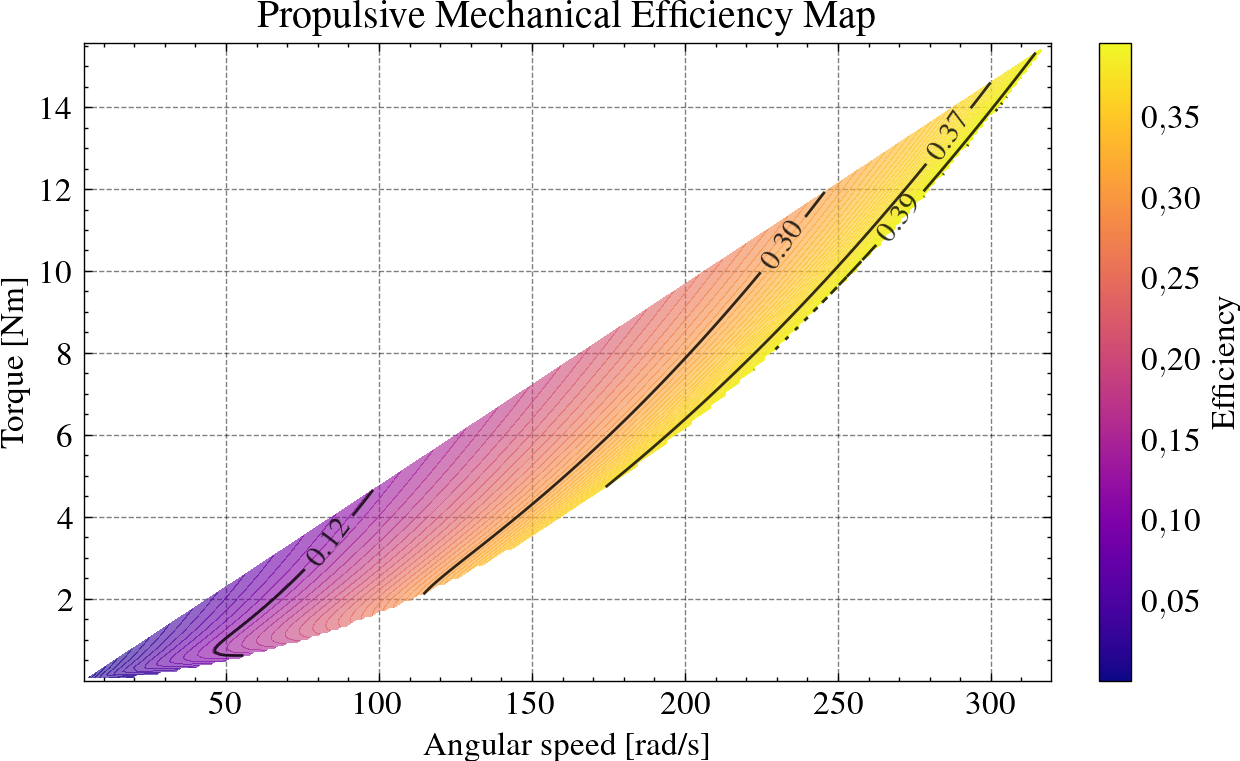

In [24]:
fig, ax, out = plot_efficiency_map_scattered(
    Y_ss,
    x='motor_w', y='motor_q_load', z='propulsive_mechanical_eta',
    nx=200, ny=200,
    mask_col='motor_p_out', mask_min=0,
    level_pmin=0, level_pmax=100, level_n=100,
    contour_lines=True,
    line_pmin=0, line_pmax=100, line_n=7,
    line_colors='k',
    label_lines=1,
    title='Propulsive Mechanical Efficiency Map',
    xlabel='Angular speed [rad/s]',
    ylabel='Torque [Nm]',
    cbar_label='Efficiency',
    cmap='plasma',
    fill_alpha=0.6,
)
plt.show()

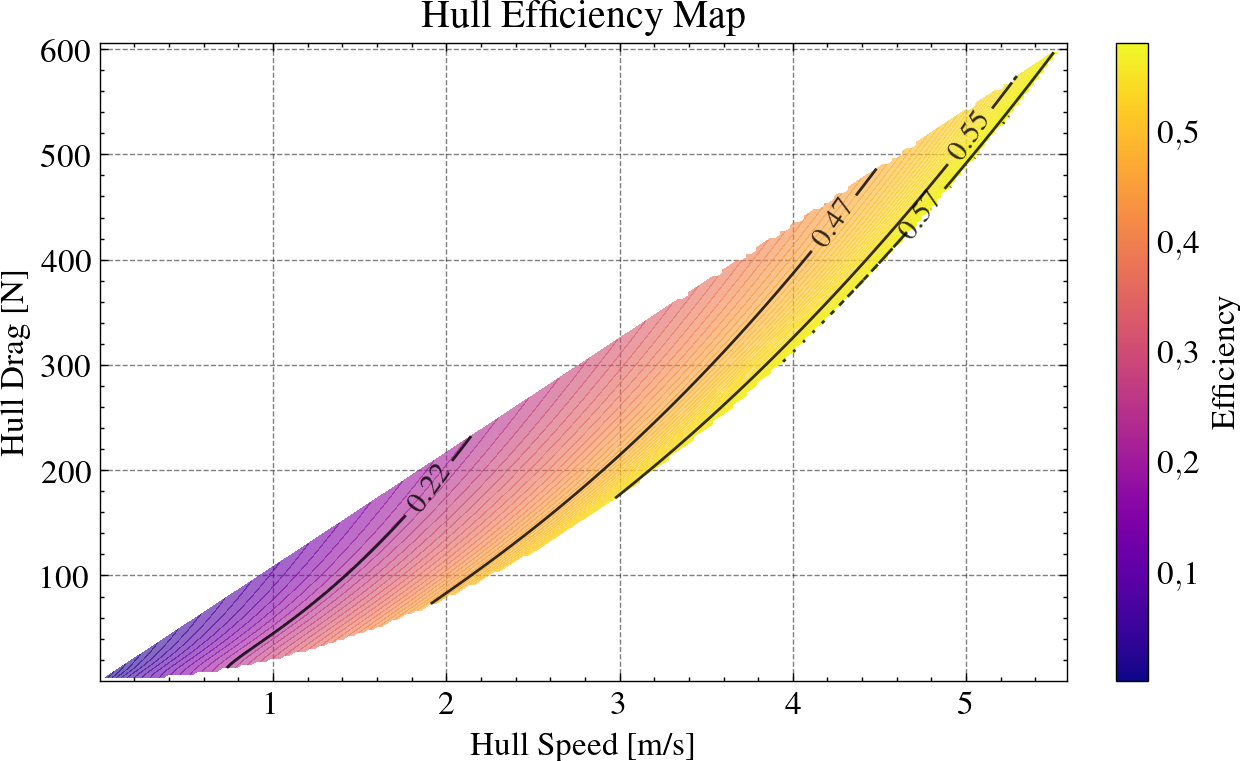

In [25]:
fig, ax, out = plot_efficiency_map_scattered(
    Y_ss,
    x='hull_u', y='hull_r', z='hull_eta',
    nx=200, ny=200,
    mask_col='motor_p_out', mask_min=0,
    level_pmin=0, level_pmax=100, level_n=100,
    contour_lines=True,
    line_pmin=0, line_pmax=100, line_n=7,
    line_colors='k',
    label_lines=1,
    title='Hull Efficiency Map',
    xlabel='Hull Speed [m/s]',
    ylabel='Hull Drag [N]',
    cbar_label='Efficiency',
    cmap='plasma',
    fill_alpha=0.6,
)
plt.show()

Text(0, 0.5, 'Propeller Advance Ratio (J)')

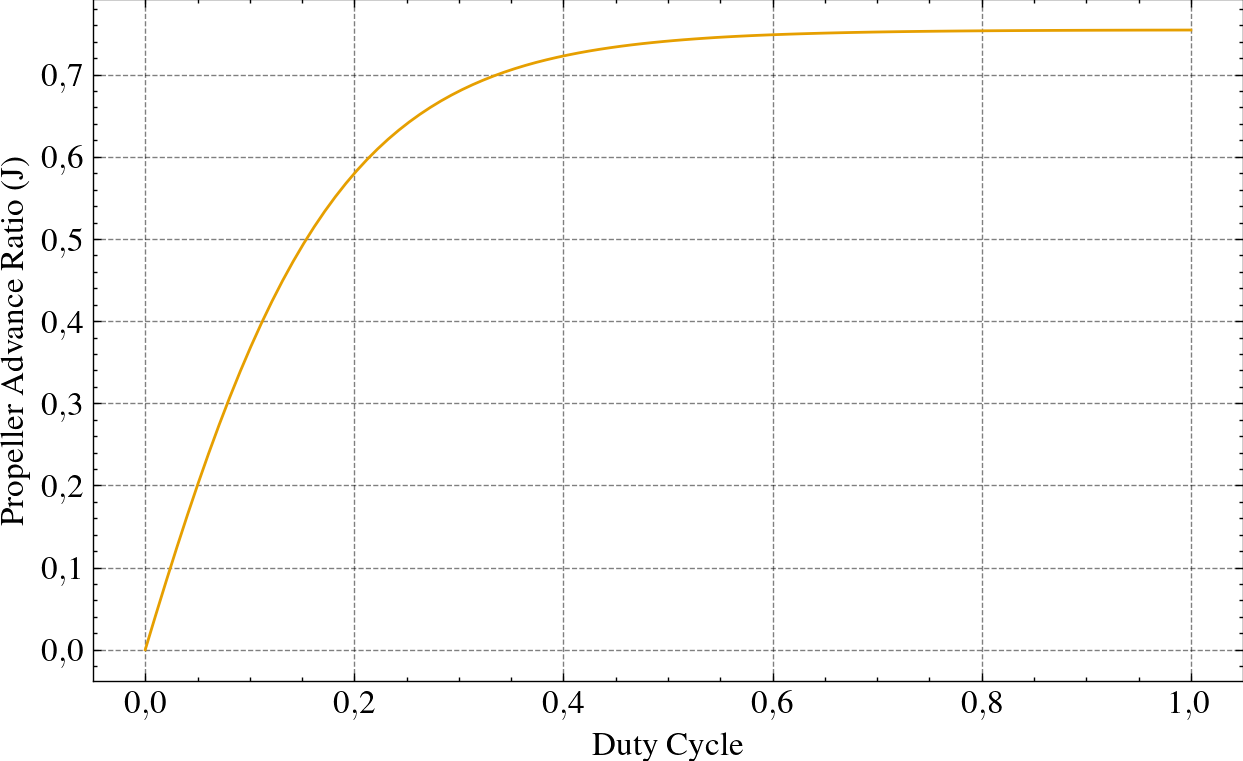

In [26]:
plt.plot(Y_ss2['esc_d'], Y_ss2['prop_J'])
plt.xlabel('Duty Cycle')
plt.ylabel('Propeller Advance Ratio (J)')

Text(0, 0.5, 'Hull speed [m/s]')

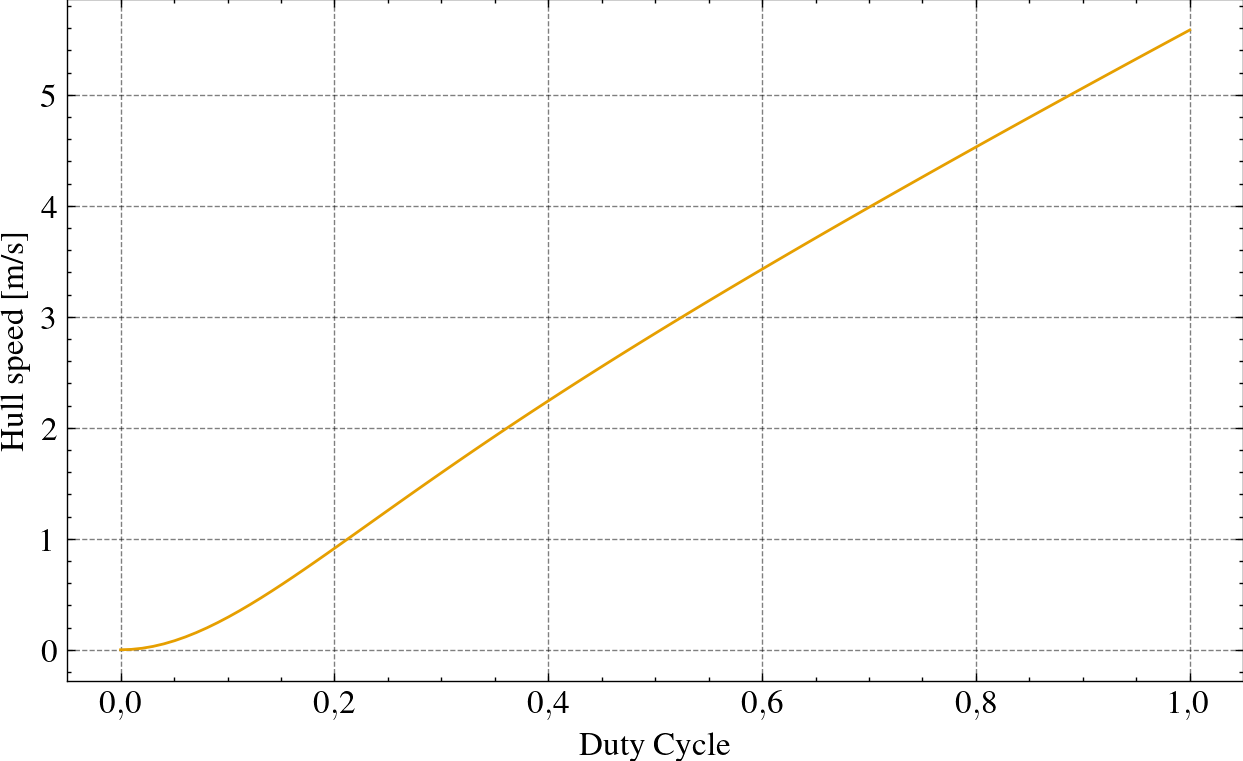

In [27]:
plt.plot(Y_ss2['esc_d'], Y_ss2['hull_u'])
plt.xlabel('Duty Cycle')
plt.ylabel('Hull speed [m/s]')

Text(0, 0.5, 'Propeller Angualr speed [rad/s]')

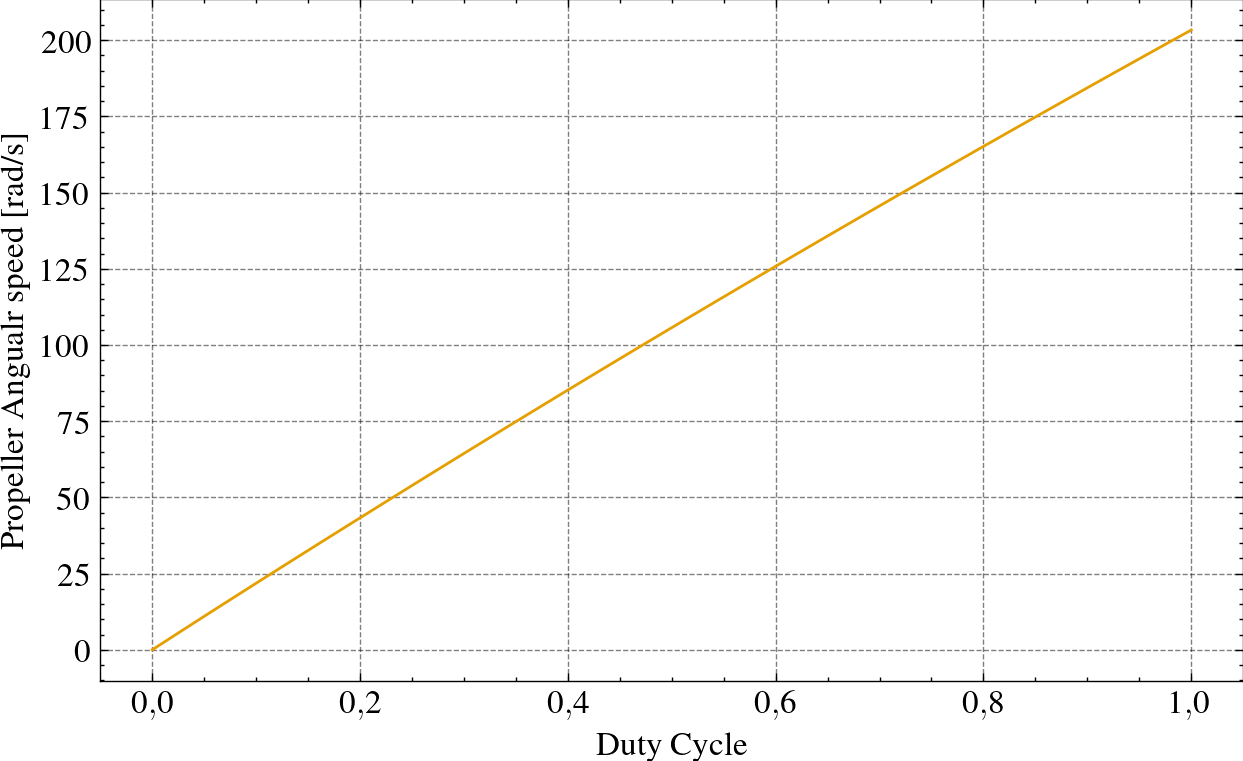

In [28]:
plt.plot(Y_ss2['esc_d'], Y_ss2['prop_w'])
plt.xlabel('Duty Cycle')
plt.ylabel('Propeller Angualr speed [rad/s]')

Text(0.5, 0, 'Propeller Angualr speed [rad/s]')

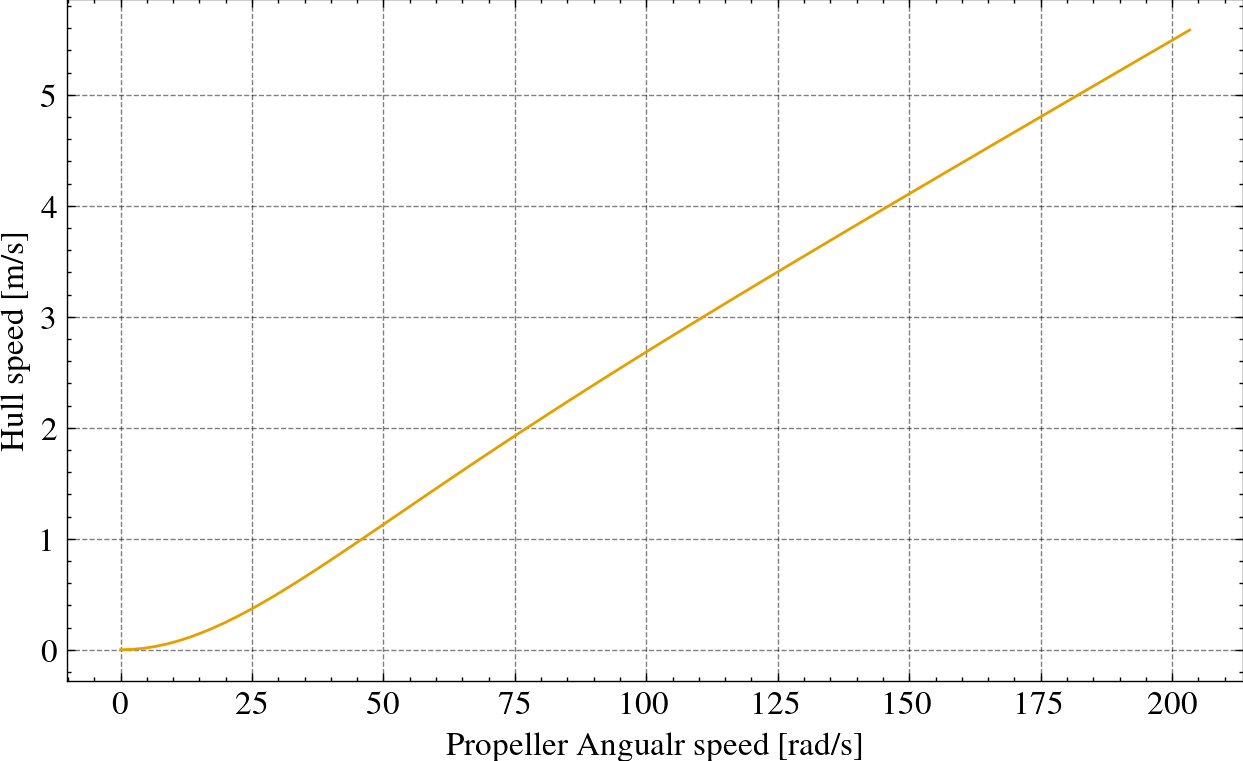

In [29]:
plt.plot(Y_ss2['prop_w'], Y_ss2['hull_u'])
plt.ylabel('Hull speed [m/s]')
plt.xlabel('Propeller Angualr speed [rad/s]')